## **Model Training, Inference, and Display**

This Jupyter Notebook is meant to be accessed via Google Colab and will be the main method to train models on Google Colab.

###Check for GPU; mount GDrive; Install requirements; import packages and functions

In [1]:
# Check if NVIDIA GPU is enabled
!nvidia-smi

Wed Sep 29 22:43:52 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   62C    P0    32W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd /content/gdrive/My Drive/Drum-Tabber
!ls

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/My Drive/Drum-Tabber
Drum-Tabber-Google-Colab-Notebook.ipynb  models		   sample_dataset
Jupyter-Notebooks			 __pycache__	   src
logs					 README.md	   train.py
model.png				 requirements.txt


In [3]:
!pip install -r ./requirements.txt

In [4]:
# primary importing code block to utilize the python files
import os
import json
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Input, LeakyReLU, BatchNormalization, MaxPool2D
from pydub import AudioSegment   # main class from pydub package used to upload mp3 into Python and then get a NumPy array
import IPython.display as ipd    # ability to play audio in Jupyter Notebooks if needed
import librosa as lb             # loads the librosa package
import librosa.display as lbdisplay
from src.configs import *
from src.utils import MusicAlignedTab, create_FullSet_df, one_hot_encode, collapse_class, clean_labels
from src.utils import save_drum_tabber_model, load_drum_tabber_model, create_configs_dict
from src.dataset import Dataset
from src.model import conv2D_block, create_DrumTabber
from src.tst import create_mask

%load_ext tensorboard

### Partial Code and New Song Testing

In [ ]:
mat = MusicAlignedTab('coffeeshop_soundtrack')
df = mat.MAT

In [ ]:
mat.mf_tab

In [ ]:
mat.alignment_checker([], 15, times_to_be_checked=[0.1, 0.2, 0.3, 0.5, 0.7, 0.9, 0.95], check_drums_only=False)

Sampling the song starting at 0.1 through the song
   204 205 206 207 208 209 210 211 212 213 214 215 216 217 218
C3   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -
HT   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -
MT   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -
LT   o   -   -   -   -   -   -   -   -   -   -   -   -   -   -
C2   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -
CC   -   -   -   -   X   -   -   -   X   -   -   -   X   -   -
RD   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -
HH   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -
SD   o   -   -   -   -   -   -   -   -   -   -   -   o   -   -
BD   -   -   -   -   o   -   -   -   o   -   -   -   o   -   -
tk   4   e   +   a   1   e   +   a   2   e   +   a   3   e   +


Sampling the song starting at 0.2 through the song
   409 410 411 412 413 414 415 416 417 418 419 420 421 422 423
C3   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -
HT   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -
MT   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -
LT   -   -   -   o   -   -   -   -   -   -   -   -   -   -   -
C2   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -
CC   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -
RD   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -
HH   -   -   -   -   -   -   -   x   -   -   -   x   -   -   -
SD   -   -   -   o   -   -   -   -   -   -   -   o   -   -   -
BD   -   -   -   -   -   -   -   o   -   o   -   -   -   -   -
tk   e   +   a   4   e   +   a   1   e   +   a   2   e   +   a


Sampling the song starting at 0.3 through the song
   613 614 615 616 617 618 619 620 621 622 623 624 625 626 627
C3   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -
HT   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -
MT   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -
LT   -   -   -   -   -   -   -   o   -   -   -   -   -   -   -
C2   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -
CC   -   -   -   -   -   -   -   -   -   -   -   X   -   -   -
RD   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -
HH   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -
SD   -   -   -   f   -   -   -   o   -   -   -   -   -   -   -
BD   -   -   -   -   -   o   -   -   -   -   -   o   -   o   -
tk   e   +   a   3   e   +   a   4   e   +   a   1   e   +   a


Sampling the song starting at 0.5 through the song
   1023 1024 1025 1026 1027 1028 1029 1030 1031 1032 1033 1034 1035 1036 1037
C3    -    -    -    -    -    -    -    -    -    -    -    -    -    -    -
HT    -    -    -    -    o    -    -    -    -    -    -    -    -    -    -
MT    -    -    -    o    -    -    -    -    -    -    -    -    -    -    -
LT    -    -    o    -    -    -    -    -    -    -    -    -    -    -    -
C2    -    -    -    -    -    -    -    -    -    -    -    -    -    -    -
CC    -    -    -    -    -    -    -    -    -    -    -    -    -    -    -
RD    -    -    -    -    -    -    -    -    -    -    -    -    -    -    -
HH    -    -    -    -    -    -    -    X    -    -    -    -    -    -    -
SD    -    o    -    -    -    o    o    -    -    -    -    -    -    -    -
BD    -    o    -    -    -    -    -    o    -    -    -    -    -    -    -
tk    a    1    t    e    2    t    e    3    e    +    a    4    e    +    a


Sampling the song starting at 0.7 through the song
   1432 1433 1434 1435 1436 1437 1438 1439 1440 1441 1442 1443 1444 1445 1446
C3    -    -    -    -    -    -    -    -    -    -    -    -    -    -    -
HT    -    -    -    -    -    -    -    -    -    -    -    -    -    -    -
MT    -    -    -    -    -    -    -    -    -    -    -    -    -    -    -
LT    -    -    -    -    -    -    -    -    -    -    -    -    -    -    -
C2    -    -    -    -    -    -    -    -    -    -    -    -    -    -    -
CC    -    -    -    -    -    -    -    -    -    -    -    -    -    -    -
RD    -    -    -    -    -    -    -    -    -    -    -    -    -    -    -
HH    -    -    O    -    -    -    O    -    -    -    O    -    -    -    O
SD    -    -    -    -    -    -    o    -    -    -    -    -    -    -    o
BD    -    -    o    -    o    -    -    -    -    -    o    -    o    -    -
tk    +    a    4    e    +    a    1    e    +    a    2    e    +    a    3


Sampling the song starting at 0.9 through the song
   1841 1842 1843 1844 1845 1846 1847 1848 1849 1850 1851 1852 1853 1854 1855
C3    -    -    -    -    -    -    -    -    -    -    -    -    -    -    -
HT    -    -    -    -    -    -    -    -    -    -    -    -    -    -    -
MT    -    -    -    -    -    -    -    -    -    -    -    -    -    -    -
LT    -    -    -    -    -    -    -    -    -    -    -    -    -    -    -
C2    -    -    -    -    -    -    -    -    -    -    -    -    -    -    -
CC    -    X    -    -    -    X    -    -    -    X    -    -    -    X    -
RD    -    -    -    -    -    -    -    -    -    -    -    -    -    -    -
HH    -    -    -    -    -    -    -    -    -    -    -    -    -    -    -
SD    -    o    -    -    -    -    -    -    -    o    -    -    -    -    -
BD    -    -    -    -    -    o    -    o    -    -    -    -    -    o    -
tk    a    2    e    +    a    3    e    +    a    4    e    +    a    1    e


Sampling the song starting at 0.95 through the song
   1943 1944 1945 1946 1947 1948 1949 1950 1951 1952 1953 1954 1955 1956 1957
C3    -    -    -    -    -    -    -    -    -    -    -    -    -    -    -
HT    -    -    -    -    -    -    -    -    -    -    -    -    -    -    -
MT    -    -    -    -    -    -    -    -    -    -    -    -    -    -    -
LT    -    -    -    -    -    -    -    -    -    -    -    -    -    -    -
C2    -    -    -    -    -    -    -    -    -    -    -    -    -    -    -
CC    -    -    -    X    -    -    -    X    -    -    -    X    -    -    -
RD    -    -    -    -    -    -    -    -    -    -    -    -    -    -    -
HH    -    -    -    -    -    -    -    -    -    -    -    -    -    -    -
SD    -    -    -    -    -    -    -    -    -    -    -    -    -    -    -
BD    -    -    -    -    -    o    -    -    -    o    -    o    -    o    -
tk    e    +    a    4    e    +    a    1    e    +    a    2    e    +    a


In [ ]:
mat_w_drums = MusicAlignedTab('sow', include_drums=True)

In [ ]:
print(len(mat.MAT), len(mat_w_drums.MAT))
print(mat.MAT.columns, mat_w_drums.MAT.columns)

1984 1984
Index(['tk', 'BD', 'SD', 'HH', 'RD', 'CC', 'C2', 'LT', 'MT', 'HT', 'CH', 'C3',
       'song slice', 'sample start'],
      dtype='object') Index(['tk', 'BD', 'SD', 'HH', 'RD', 'CC', 'C2', 'LT', 'MT', 'HT', 'CH', 'C3',
       'song slice', 'sample start', 'drums slice'],
      dtype='object')


In [ ]:
df = clean_labels(df)
MusicAlignedTab.labels_summary(df)
df = collapse_class(df, keep_dynamics = False, keep_bells = False, keep_toms_separate = False, hihat_classes=1, cymbal_classes=1)
MusicAlignedTab.labels_summary(df)

In [ ]:
encode_df = one_hot_encode(df)
print(encode_df.columns)
encode_df.head()

In [ ]:
MusicAlignedTab.labels_summary(encode_df)

---Unique values and frequencies by column name---
            0    1
tk_beat  1488  496

                0    1
tk_downbeat  1860  124

         0    1
BD_o  1319  665

         0    1
SD_o  1525  459

         0   1
at_o  1917  67

         0    1
ac_x  1417  567



###FullSet Testing

In [ ]:
def play(samples, sr=44100):
    '''
    Helper function just so I can type play(samples) to get the song output
    '''
    return ipd.Audio(samples, rate = sr)

In [ ]:
FullSet = create_FullSet_df(SONGS_PATH)
FullSet_clean = clean_labels(FullSet)
MusicAlignedTab.labels_summary(FullSet_clean)
FullSet_collapse = collapse_class(FullSet_clean, keep_dynamics = False, keep_bells = False, keep_toms_separate = False, hihat_classes=1, cymbal_classes=1)
MusicAlignedTab.labels_summary(FullSet_collapse)
FullSet_encoded = one_hot_encode(FullSet_collapse)

In [ ]:
tset = Dataset('train', FullSet_encoded)
vset = Dataset('val', FullSet_encoded)

In [ ]:
song_idx = 1
print(lb.__version__)

0.6.3


In [ ]:
%%time
song_df = tset.subset_df.loc[tset.song_list[song_idx]].copy()
song = np.vstack(song_df['song slice'].to_numpy()).T   # stacks the song slices back into a single numpy array of shape (channels, samples)
mono_song = lb.core.to_mono(song)
channels = [mono_song]              # channels is a list of either [mono_song] or [mono, L_song, R_song]
if INCLUDE_LR_CHANNELS:             # appending the LR channels to the channels variable
    channels.append(song[0,:])
    channels.append(song[1,:])
aug_channels = tset.augment_audio_cp(channels, tset.aug_comp, sr=SAMPLE_RATE)

In [ ]:
numpysave_fp = '/content/gdrive/My Drive/Drum-Tabber-Support-Data/Experimental/'
fy_spec = np.load(numpysave_fp+'fy_spec.npy')
fy_tar = np.load(numpysave_fp+'fy_tar.npy')
mb_spec = np.load(numpysave_fp+'mb_spec.npy')
mb_tar = np.load(numpysave_fp+'mb_tar.npy')
print(mb_spec.shape)

(150, 20804, 3)


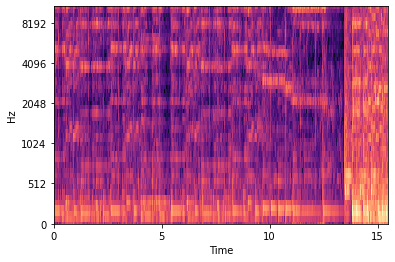

In [ ]:
lb.display.specshow(mb_spec[:50,0:1550,0], sr=44100, hop_length=441,
                    x_axis = 'time' , y_axis = 'mel')

In [ ]:
activ = 'relu'
n_features = 100
input_layer = Input(shape = (n_features, (N_CONTEXT_PRE+1+N_CONTEXT_POST), 1, ), dtype = 'float32') 
print('Input layer shape: ', input_layer.shape)
freq_branch = conv2D_block(input_layer, 64,  kernel_shape = (3,10), strides_arg = (1,1), activation = activ)
print(freq_branch.shape)
freq_branch = conv2D_block(freq_branch, 64,  kernel_shape = (3,10), strides_arg = (1,1), activation = activ)
print(freq_branch.shape)
freq_branch = MaxPool2D(pool_size = (2,2), strides=None, padding = 'same')(freq_branch)
print(freq_branch.shape)

Input layer shape:  (None, 100, 31, 1)
(None, 100, 31, 64)
(None, 100, 31, 64)
(None, 50, 16, 64)


In [ ]:
time_branch = conv2D_block(input_layer, 64,  kernel_shape = (10,3), strides_arg = (1,1), activation = activ) # note that input layer goes here as well
print(time_branch.shape)
time_branch = conv2D_block(time_branch, 64,  kernel_shape = (10,3), strides_arg = (1,1), activation = activ)
print(time_branch.shape)
time_branch = MaxPool2D(pool_size = (2,2), strides=None, padding = 'same')(time_branch)
print(time_branch.shape)

(None, 100, 31, 64)
(None, 100, 31, 64)
(None, 50, 16, 64)


In [ ]:
timefreq = tf.keras.layers.Concatenate()([freq_branch, time_branch])
print(timefreq.shape)
timefreq = conv2D_block(timefreq, 256,  kernel_shape = (3,3), strides_arg = (1,1), activation = activ)
print(timefreq.shape)
timefreq = conv2D_block(timefreq, 512,  kernel_shape = (3,3), strides_arg = (1,1), activation = activ)
print(timefreq.shape)
timefreq = MaxPool2D(pool_size = (2,2), strides=None, padding = 'same')(timefreq)
print(timefreq.shape)
timefreq_1x1 = conv2D_block(timefreq, 64,  kernel_shape = (1,1), strides_arg = (1,1), activation = activ)
print('timefreq 1x1 shape:', timefreq_1x1.shape)
output = tf.keras.layers.Flatten()(timefreq_1x1)
print(output.shape)
output = tf.keras.layers.Dense(512, activation = activ)(output)
print(output.shape)

(None, 50, 16, 128)
(None, 50, 16, 256)
(None, 50, 16, 512)
(None, 25, 8, 512)
timefreq 1x1 shape: (None, 25, 8, 64)
(None, 12800)
(None, 512)


### **Training a model using train.py, and watch using Tensorboard**

In [5]:
%%time
from train import *
trained_model = main('TST_diag3')

drum_tabber model has been built!
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 250, 32)]         0         
_________________________________________________________________
embedding_layer (EmbeddingLa (None, 32, 512)           128512    
_________________________________________________________________
positional_encoding_layer (P (None, 32, 512)           16384     
_________________________________________________________________
transformer_encoder (Transfo (None, 32, 512)           17861632  
_________________________________________________________________
self_supervised_layer (SelfS (None, 32, 250)           128250    
_________________________________________________________________
tf.compat.v1.transpose (TFOp (None, 250, 32)           0         
Total params: 18,134,778
Trainable params: 18,130,682
Non-trainable params: 4,096
___________

KeyboardInterrupt: ignored

In [6]:
save_model_path = os.path.join(SAVED_MODELS_PATH, 'TST_4')
trained_model.save(filepath=save_model_path, overwrite = True)

INFO:tensorflow:Assets written to: /content/gdrive/My Drive/Drum-Tabber/models/saved_models/TST_4/assets


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/Drum-Tabber/models/saved_models/TST_4/assets


In [ ]:
%tensorboard --logdir logs

### Loading back in a saved model, configs_dict, and sample song

{'class_names_dict': {'0': 'tk_beat', '1': 'tk_downbeat', '2': 'BD_o', '3': 'SD_o', '4': 'HH_x', '5': 'at_o', '6': 'ac_x'}, 'num_classes': 7, 'num_features': 150, 'num_channels': 1, 'n_mels': 150, 'model_type': 'TimeFreq-CNN', 'window_size': 2048, 'fmax': 10000, 'hop_size': 441, 'shift_to_db': True, 'n_context_pre': 15, 'n_context_post': 15, 'include_fo_differential': False, 'negative_window_fraction': 0.15, 'positive_window_fraction': 0.15, 'tolerance_window': 20, 'classification_dict': {'clean_data': True, 'keep_dynamics': False, 'keep_bells': False, 'keep_toms_seperate': False, 'hihat_classes': 1, 'cymbal_classes': 1}, 'month_date': '-Jul-09', 'training_dict': {'train_data_aug': True, 'train_epochs': 50, 'include_drum_stem': True, 'train_batch_size': 256, 'train_fine_tune': False}}


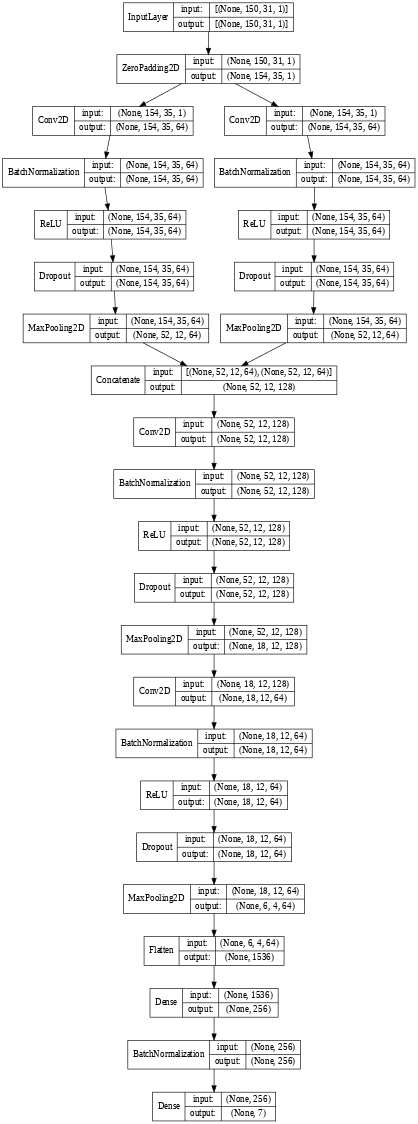

In [ ]:
# load a model back in 
model_to_load_name = 'TimeFreq_1D_longer_complex'
loaded_model, loaded_configs = load_drum_tabber_model(model_to_load_name, SAVED_MODELS_PATH)
print(loaded_configs)
tf.keras.utils.plot_model(loaded_model, dpi=45, show_shapes = True, show_layer_names = False)

In [ ]:
# load sample song and make spectrogram
song_to_test = 'track_8'
samp_song, sr_song = lb.core.load(os.path.join(SONGS_PATH,song_to_test,song_to_test+'_drums.mp3'), sr=None, mono=True)
exper_song_to_test_path = '/content/gdrive/My Drive/Drum-Tabber-Support-Data/Songs-that-dont-work-yet/let_it_enfold_you/let_it_enfold_you.mp3'
#samp_song, sr_song = lb.core.load(exper_song_to_test_path, sr=None, mono=True)
print(f'Number of samples in song is {samp_song.shape[0]}')
spectro = lb.feature.melspectrogram(np.asfortranarray(samp_song), sr = sr_song, n_fft=loaded_configs['window_size'], hop_length = loaded_configs['hop_size'], center = False, n_mels = loaded_configs['n_mels'], fmax= loaded_configs['fmax'])
if loaded_configs['shift_to_db']:
    spectro = lb.power_to_db(spectro, ref = np.max)
spectro_norm = (spectro - spectro.mean())/spectro.std()
spectro_div = (spectro+  80)/80
if loaded_configs['include_fo_differential']:
    spectro_ftd = lb.feature.delta(data = spectro, width = 9, order=1, axis = -1) 
        # spectro_f(irst)t(ime)d(erivative).shape = (n_mels, t) SAME AS spectro
        # manual normalize of current spectro_ftd
    spectro_ftd_norm = (spectro_ftd - spectro_ftd.mean())/spectro_ftd.std()
    spectro_norm = np.concatenate([spectro_norm, spectro_ftd_norm], axis = 0)
        # spectro.shape = (2* n_mels, t)

spectrogram = spectro_div.copy()    # choosing spectro_div
n_features, n_windows = spectrogram.shape
print(f'spectrogram shape is {spectrogram.shape}')
if loaded_configs['model_type'] in ['Context-CNN', 'TimeFreq-CNN', 'TL-DenseNet121', 'TL-DenseNet169', 'TL-DenseNet201']:

    pre_context, post_context = loaded_configs['n_context_pre'], loaded_configs['n_context_post']
    input_width = pre_context + 1 + post_context
    min_value = np.min(spectrogram)

    # assign into this np.array filled with the min values of the spectrogram (silence)
    input_array = np.full(shape = (n_windows, n_features, input_width), fill_value = min_value)

    for idx in range(n_windows):
        if idx - pre_context < 0:    # in a window where you would slice before the beginning
            start = pre_context-idx
            input_array[idx, :, start:] = spectrogram[:, 0:idx+post_context+1]
        elif idx + post_context+1 > n_windows: # in a window where you would slice past the end
            end = post_context+1 - (n_windows - idx)
            input_array[idx, :, :input_width-end] = spectrogram[:, idx-pre_context: n_windows ]
        else:    # in a "normal" middle window where you slice into the spectrogram normally
            input_array[idx, :,:] = spectrogram[:, idx-pre_context : idx+post_context+1]

if loaded_configs['model_type'] in ['Context-CNN', 'TimeFreq-CNN']:
    channel_number = 1
elif loaded_configs['model_type'] in ['TL-DenseNet121', 'TL-DenseNet169', 'TL-DenseNet201']:
    channel_number = 3  # simulating RGB color channels

input_array = np.stack([input_array for _ in range(channel_number)], axis=-1)

print(f'input array shape is {input_array.shape}')

/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Number of samples in song is 8869980
spectrogram shape is (150, 20109)
input array shape is (20109, 150, 31, 1)


In [ ]:
# making predictions on the sample song
start_ind = 0
num_ind = 500
end_ind = start_ind + num_ind
predictions = loaded_model(input_array[start_ind:end_ind,:,:,:], training=False)
print('predictions.shape:', predictions.shape)
print(f'Your selection starts at {int(start_ind/6000)}:{int((start_ind/100) % 60)} and ends at {int(end_ind/6000)}:{int((end_ind/100) % 60)}')

predictions.shape: (500, 7)
Your selection starts at 0:0 and ends at 0:5


prediction peaks = [  8  40  64  80  98 150 169 237 275 311 381 394 433 452 467 487]
prediction peaks = [  8  28  43  64  99 169 237 258 275 293 310 346 381 434 452 487]
prediction peaks = [ 28  64 169 258 311 346 452 487]
prediction peaks = [  8  46  98 152 222 275 293 381 434 499]
prediction peaks = [  8  43  96 149 325 485]
Your selection starts at 0:0 and ends at 0:5


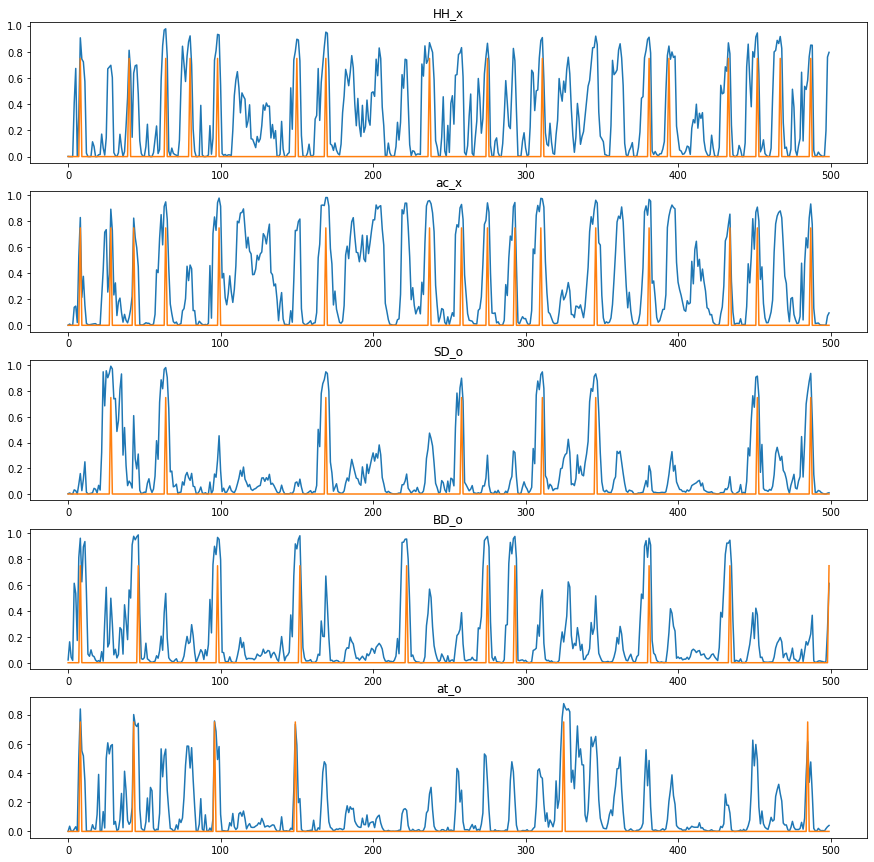

In [ ]:
diff_samples = 1500 # every "sample" here is 10 ms. 100 = 1 sec, 1000 = 10 sec
start = 0
end = start + diff_samples

classes_to_show = [4,6,3,2,5]   # { 0:tk_beat, 1:tk_downbeat, 2:BD_o, 3:SD_o, 4:HH_x, 5:at_o, 6:ac_x}
num_to_show = len(classes_to_show)

# making a plot to output
# plt.rcParams["figure.figsize"]=15,3*num_to_show
fig, axs = plt.subplots(num_to_show, figsize = (15, 3*num_to_show))

for idx, val in enumerate(classes_to_show):

    pred = predictions[start:end,val].numpy()
    pred_peaks = np.zeros(shape = pred.shape)
    pred_peaks_idx = lb.util.peak_pick(x = pred, pre_max = 5, post_max = 5, pre_avg = 20, post_avg = 20, 
                                delta = 0.5, wait = 10)

    print(f'prediction peaks = {pred_peaks_idx}')
    if len(pred_peaks_idx) != 0:
        pred_peaks[pred_peaks_idx] = 0.75

    axs[idx].plot(pred)
    axs[idx].plot(pred_peaks)
    axs[idx].set_title(loaded_configs['class_names_dict'][str(val)])
print(f'Your selection starts at {int(start_ind/6000)}:{int((start_ind/100) % 60)} and ends at {int(end_ind/6000)}:{int((end_ind/100) % 60)}')


In [ ]:
_ = plt.hist(spectrogram.flatten(), bins='auto')
plt.show()

In [ ]:
plt.hist(lb.feature.delta(data = normed_fy, width=9, order=1, axis=-1).flatten(), bins='auto')

In [ ]:
fy_ftd = lb.feature.delta(data = fy, width=9, order = 1, axis=-1)
_ = plt.hist(fy_ftd.flatten(), bins='auto')
plt.show()

#### Load Time Series Transformer Model back in to test things


In [6]:
# loading back in a saved tst model
tst_model_name = 'TST_4'
#tst = tf.keras.models.load_model(os.path.join(SAVED_MODELS_PATH, tst_model_name))
tst= trained_model



In [6]:
# loading back in a weights-saved tst model
tst_weights = create_DrumTabber(n_features = D_FEATURES_IN,
                                        n_classes = D_OUT,
                                        activ = ACTIV,
                                        training = False)
tst_weights_model_name = 'TSTTST_diag3'
tst_weights_path = os.path.join(TRAIN_CHECKPOINTS_FOLDER, tst_weights_model_name)
tst_weights.load_weights(tst_weights_path)
tst = tst_weights



In [7]:
# loading back in a test spectrogram
artist_name = 'Hands Like Houses'
album_name = 'Unimagine'
with np.load(os.path.join(SPECTROS_PATH, artist_name, album_name+'.npz')) as loaded:
    alb = loaded.files
    spectro_dict = {s: loaded[s] for s in alb}
print(spectro_dict.keys())

dict_keys(['01 Developments', '02 Introduced Species', '03 Weight', '04 Shapeshifters', '05 The House You Built', '06 A Tale of Outer Suburbia', '07 Oceandust', '09 Fountainhead', '08 No Parallels', '10 Wisteria', '11 A Fire On a Hill'])


This songs spectrogam shape is (250, 21939)


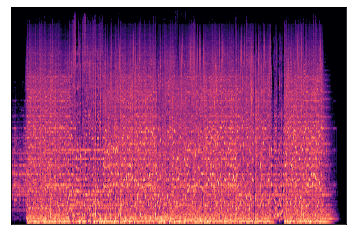

In [8]:
# loading in spectrogram and showing the original full spectro
spectro = spectro_dict['01 Developments']
print(f'This songs spectrogam shape is {spectro.shape}')
lbdisplay.specshow(spectro, hop_length=441, sr=44100)

(250, 32) -41.626205


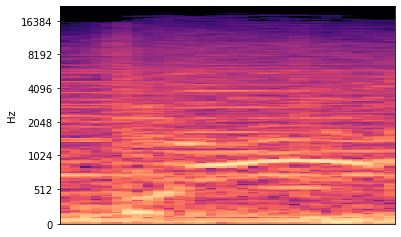

In [157]:
# slicing a inference-shaped spectrogram slice and displaying it
slice_loc = 9_100
spectro_slice = spectro[:, slice_loc:slice_loc + LEN_SEQ]
print(spectro_slice.shape, spectro_slice.mean())
lbdisplay.specshow(spectro_slice, hop_length=441, sr=44100, y_axis='mel')

Loss 0.0049213376


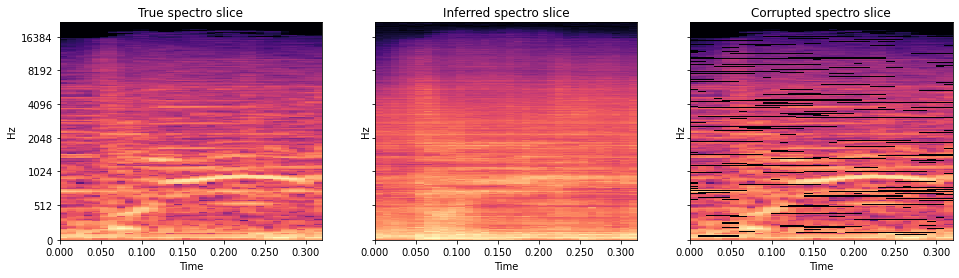

In [164]:
# prepping for inference on the loaded model
spectro_slice_norm = (spectro_slice+80.0)/80.0

# mask creation
mask_slice = create_mask(np.expand_dims(spectro_slice,axis=0), r=0.15, lm=MASK_LM, random_type_list=['seq'])[0]
masked_spectro_slice_norm = np.multiply(spectro_slice_norm, ~mask_slice)

# inference and scaling back
infer = tst([masked_spectro_slice_norm])[0].numpy()
infer_standard = (infer*80.0) - 80.0


# plotting all 3 spectro slices
fig, axs = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(16,4))

img1 = lbdisplay.specshow(spectro_slice, hop_length=441, sr=44100, ax=axs[0], y_axis='mel', x_axis='time')
axs[0].set(title='True spectro slice')
img2 = lbdisplay.specshow(infer_standard, hop_length=441, sr=44100, ax=axs[1], y_axis='mel', x_axis='time')
axs[1].set(title='Inferred spectro slice')
img3 = lbdisplay.specshow((masked_spectro_slice_norm*80) - 80, hop_length=441, sr=44100, ax=axs[2],y_axis='mel', x_axis='time')
axs[2].set(title='Corrupted spectro slice')
#fig.colorbar(img3)
print('Loss', tf.keras.losses.MeanSquaredError()(infer[mask_slice], spectro_slice_norm[mask_slice]).numpy())

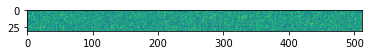

In [133]:
plt.imshow(tst.pe_layer.weights[0].numpy())

## **Development**

The different sections below detail the work done in the development of additional features for this project *after moving to Google Colab* for training. This work is done by Thomas Hymel alone. This type of development work was previously split across multiple separate Jupyter Notebooks (available in the Github repo). Here, it will be split across different collapsable sections for ease of navigation. 

### Potential Spleeter-integration for "augmentation" 


[Spleeter](https://github.com/deezer/spleeter) library by Deezer is a source separation model that takes in an audio file and outputs multiple audio files, where each one is supposed to be the stem, or source, of various different components of a song (vocals, drums, bass, piano, other). One idea is to use Spleeter as a pre-processing tool to produce drum stems as additional "drum channels" while training. Currently (Dec. 15th, 2020) all models are being trained on full song mixes, but the code is set up to handle multiple "channels" per song during training. This functionality was originally created for including the left and right channels, individually, (in addition to the mono channel) during training. However it has become clear to me that using the left/right channels alone is not significantly different enough to justify not simply multiplying your epochs by 3 and then training with data augmentation on, transforming each song's training instance into an even better slightly different version of the song. 

With Spleeter implemented directly into the pipeline, one can imagine each training song can be split into its different stems and then multiple options can occur. 

1. The drum stem can be used directly as an additional channel for training with its full song mix. With this option, it must be assumed that the label targets are unchanged. To verify this assumption, lots of songs should be split by Spleeter and listened to by a human. If the drum stem is missing significant amounts of any drum class, *and then* the target labels claim they are still there, this option may hurt more than help. 
2. The drum stem can be used as a "mixing" component with the full song mix to accent the drums in the original full song mix. In this option, the problem of a drum class not being present in the Spleeter drum stem is resolved because it must be present in the full song mix. The drum stem and full song would be linearly added together with some weight (verified by a human ear) to produce a new channel for each song (or to completely override the full song mix mono channel?)

On Dec. 19th, 2020, the decision was made to run the training set songs through Spleeter first, and then save the drums-only audio stem in the same folder as the full mix audio. In this way Spleeter needs to only run once, and not every time a song is preprocessed in the training, significantly cutting down on preprocessing time. Certain functions needed to be slightly changed to accommodate the addtional audio file and samples, but it was done pretty easily given the fact that the Spleeter output files have *exactly* the same number of samples as the original audio file. This fact allowed me to just reuse most of the code that is used to load in the regular full mix audio. 

It is still being explored whether this Spleeter drum stem is helpful to the overall performance of the model. More short training sessions will need to be done to compare the output performance of the models. 

In [ ]:
# install spleeter, probably need to restart runtime to install properly
!pip install spleeter==2.0      # need to install this version because it works and any future version (2.1) doesn't work properly so... 

In [ ]:
import os
from src.configs import *
import librosa as lb
import IPython.display as ipd    # ability to play audio in Jupyter Notebooks if needed

# load in the main class that does the separating from spleeter
import spleeter
from spleeter.separator import Separator
separator = Separator('spleeter:4stems')

In [ ]:
song_name = 'thats_what_you_get'
specific_song_dir = os.path.join(SONGS_PATH,song_name)

# load in a stereo song to spleet using librosa
song_to_spleet, sr_song = lb.core.load(os.path.join(specific_song_dir,song_name+'.mp3'), sr=None, mono=False) # spleeter requires stereo





In [ ]:
split_stems = separator.separate(song_to_spleet.T)

In [ ]:
# function to help with spleeting all the drum parts from the training dataset songs
def spleet_and_save_drum_stem(separator, song_name, songs_path):
    '''
    Helper function used to load a song, spleeter it, and then save the drum stem only mp3 to the same folder

    Args:
        separator [Separator]: spleeter saparator class used to spleet
        song_name [str]: the song name corresponding to the name in the main Songs folder
        songs_path [str]: the main Songs folder filepath

    Returns:
        np.array: numpy array corresponding to the drum stem only
    '''

    specific_song_dir = os.path.join(songs_path,song_name)

    # load in a stereo song to spleet using librosa
    song_to_spleet, sr_song = lb.core.load(os.path.join(specific_song_dir,song_name+'.mp3'), sr=None, mono=False) # spleeter requires stereo
    print(f'Song_to_spleet name: {song_name}, shape: {song_to_spleet.shape}, and sample rate: {sr_song}')


    # use the separator object to split the song into stems, then extract the drum stem only
    split_stems = separator.separate(song_to_spleet.T)
    drum_only_dict = {key:val for key,val in split_stems.items() if key =='drums'} # getting only the drum stem into a dictionary

    assert drum_only_dict['drums'].T.shape == song_to_spleet.shape, 'Drum shape and song shape are not the same!'

    # saves only the drum stem to the correct filename and location
    separator.save_to_file(sources = drum_only_dict, 
                       audio_descriptor = os.path.join(specific_song_dir, song_name+'.mp3'), 
                       destination = specific_song_dir,
                       filename_format = '{filename}_drums.{codec}',
                       codec = 'mp3',
                       bitrate = '320k',
                       synchronous = True
                       )
    
    return drum_only_dict['drums'].T


In [ ]:
# testing of the above function
song_name_to_spleet = 'dont_exist'
durms = spleet_and_save_drum_stem(separator = separator, 
                                  song_name = song_name_to_spleet, 
                                  songs_path = SONGS_PATH)

In [ ]:

'''
all_songs_names = [x.name for x in os.scandir(SONGS_PATH) if x.is_dir()]
print(all_songs_names, SONGS_PATH)
print(f'Number of total songs is {len(all_songs_names)}')
'''

''' BATCH SPLEET FOR DRUM TRACKS AND SAVE OF ALL SONGS IN SONGS_PATH '''

songs_to_spleet = ['coffeeshop_soundtrack', 'track_8']
all_drum_stems = []
for song_ in songs_to_spleet:
    print(song_)
    durms = spleet_and_save_drum_stem(separator = separator, song_name = song_, songs_path = SONGS_PATH)
    all_drum_stems.append(durms)
    print(f'Successfully saved {song_}')
    

In [ ]:

drum_stem = split_stems['drums'].T  # the numpy array of the drum stem in shape of (n_samples, 2), so we transpose to get it back to channels first
vocal_stem = split_stems['vocals'].T
other_stem = split_stems['other'].T
bass_stem = split_stems['bass'].T
drumless = (vocal_stem + other_stem + bass_stem)/3
voxless = (drum_stem + other_stem + bass_stem)/3
print(drum_stem.shape)
start, end = 35, 65

In [ ]:

# test playing the original song
ipd.display(ipd.Audio(song_to_spleet[:,start*sr_song:end*sr_song], rate = sr_song))

In [ ]:
# test playing the vocal stem only
ipd.display(ipd.Audio(vocal_stem[:,start*sr_song:end*sr_song], rate = sr_song))

In [ ]:
# test playing the drum stem only
ipd.display(ipd.Audio(drum_stem[:,start*sr_song:end*sr_song], rate = sr_song))

In [ ]:
# test playing the voxless combo
ipd.display(ipd.Audio(voxless[:,start*sr_song:end*sr_song], rate = sr_song))

In [ ]:
# test playing the drumless combo
ipd.display(ipd.Audio(drumless[:,start*sr_song:end*sr_song], rate = sr_song))

In [ ]:
# test playing the drum stem only
weights= {'full': 0.1, 'drums': 0.9}
weighted_sum = weights['full']*song_to_spleet + weights['drums']*drum_stem
ipd.display(ipd.Audio(weighted_sum[:,start*sr_song:end*sr_song], rate = sr_song))

### Transformer-Based Attention Model Architecture
**This section has been rendered obsolete by my implementation of time series transformer framework, done in a different Jupyter Notebook because it was coded for generic time series data.**

The main effort so far in automatic drum transcription has been using CNNs and RCNNs, including the most recent attempt with Magenta Expanded Groove MIDI Dataset released in early 2020. That model, for example, used a log mel spectrogram of 250 bins as input and an architecture of [2x[Conv with BatchNorm] + MaxPool + Dropout] + Conv with BatchNorm + MaxPool + Dropout + Dense + Droupout + BiLSTM + Dropout + Dense Class Output. So far in ADT, there has not been a transformer-based attention model architecture in print. 

I will attempt to create a transformer-based model incorporating attention in TensorFlow and then train it using the train.py script. The development of the transformer attributes will be done in this section. 

**Background Sources and Inspiration for Transformer Use**

The main paper that started the transformer attention-based architecture trend is the "Attention is all you need" [paper](https://https://arxiv.org/abs/1706.03762) coming out of Google Research. Most sources that explain transformers use text-based, NLP projects for motivations as examples (because that's what they are very good for at the moment). Tensorflow has a Transformer Jupyter Notebook [tutorial](https://www.tensorflow.org/tutorials/text/transformer) for language translation that is probably useful as a template to learn how to implement a transformer based model. [This Medium article](https://medium.com/tensorflow/a-transformer-chatbot-tutorial-with-tensorflow-2-0-88bf59e66fe2) also seems very good in explaining and stepping through a transformer model creation, similar to the Tensorflow tutorial ([link to TF blog of same post](https://blog.tensorflow.org/2019/05/transformer-chatbot-tutorial-with-tensorflow-2.html)). 

For NLP tasks, words are normally embedded in a high dimension space as a pre-processing step (word embeddings), such that a word is represented by a single n-dimensional vector. Thus a sentence could be seen as an ordered sequence of embedded word vectors. A sentence in one language contains meaning that can be translated to a different language that "contains" the same meaning, and, assuming you have enough examples of that mapping, a model should be able to learn that mapping. Note that transformers usually have an embedding layer *that is learned while the rest of the model is being trained*. You can use a pre-trained embedding layer if you want though. 

Likewise, assuming you pre-process a song into a spectrogram, a spectrogram of a full song can be seen as an ordered sequence of n-dimensional "word" vectors, where each vector represents some small time step of the song. A song in this representation "contains" the meaning of drum onsets, somewhere, so if you have enough examples of that mapping from those sequence of vectors to drum onsets, then a model should be able to learn that mapping. I am attempting to view a spectrogram'ed song as one sequenced "language", and the tabs' drum labels as another sequenced "language", and a transformer, attention-based model should be able to find the mapping between the spectrogram and the drum labels. 

For specific audio-based transformer examples, the internet is lacking in them. [Linked here](https://codeburst.io/how-to-use-transformer-for-audio-classification-5f4bc0d0c1f0) is a codeburst.io article on using Transformers for Audio Classification (based on the Tensorflow tutorial above), with the github link to the Jupyter Notebook [here](https://github.com/facundodeza/transfomer-audio-classification/blob/master/audio_classification_transformer.ipynb). However it doesn't go too in depth into the construction of the model, or at least not any more than the other tutorial above. I am mainly interested in how to handle the spectrogram sequence (positional encoding?) without the concept of "vocabulary" and embeddings used in that way. There doesn't exist a vocabulary in spectrogram slices, only different amounts of weight in each vectors. 

After some consideration I will attempt to follow along with [this article](https://trungtran.io/2019/04/29/create-the-transformer-with-tensorflow-2-0/), which describes a highly detailed implementation of the transformer architecture in TensorFlow. I will try to massage my understanding of the inputs and outputs into a useful method here with the data that I have. 

##### **Implementing the Encoder of the Transformer**

The Encoder is made up of four components: 
1. Embedding 
2. Positional Encoding
3. Multi-Head Attention
4. Position-wise Feed-Forward Network

The embedding step is usually done by a seperate network, where the embeddings of different words are learned. However we can think of each slice of a spectrogram as the embedding of that particular part of the song in time, just like we can think of a word as a particular part of a sentence. **So the embedding for the Drum-Tabber application can considered to be already finished**. 

The positional encoding will be similar. Words and sentences have order, but because we are getting rid of RNNs we can't learn from the order. We can get around this with positional encoding. The positional encoding is computed to be the following (as shown in the Attention is All You Need paper):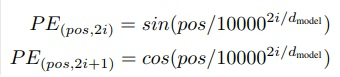

In [ ]:
import tensorflow as tf
import numpy as np

# function1
def positional_encoding(position, model_size):
    '''
    Creates the positional encoding vector used to add to the inputs of a transformer model

    Args:
        position [int]: the position of the current slice in the sequence of the spectrogram input
        model_size [int]: the size of the embedding vector - in our case, how many rows are in the spectrogram
    Returns:
        np.ndarray or tf.array?
    '''
    pe = np.zeros((1,model_size))
    for i in range(model_size):
        if i % 2 == 0 :   # if current index in embedding vector is even, use sin. Else cosine
            pe[:,i] = np.sin(position / (10000 ** (i / model_size) ) )
        else:
            pe[:,i] = np.cos(position / (10000 ** (i / model_size) ) )
    return pe

# test code of positional_encoding function
model_size = 150   # number of mel bins / height of spectrogram
len_of_sequence = 300
pe_inputs = [positional_encoding(i, model_size) for i in range(len_of_sequence)]  # the positional encodings for an embedding size of model_size and a spectrogram/input sequence length of len_of_sequence
pe_inputs = np.concatenate(pe_inputs, axis=0)   # length of sequence (number of rows) x model_size (number of columns)
print(pe_inputs.shape)

(300, 150)


To implement the multi-head attention, the tutorial that I am following creates a new class that extends the keras Model. Cool, I know how to do that. It initializes by being given a model_size and an h value, which is the total number of heads that are requested for the architecture. I'm pretty sure there already is a Keras layer for MultiHeadAttention now, [detailed here](https://keras.io/api/layers/attention_layers/multi_head_attention/), so I don't think I actually need this class anymore. 

The model size is the size of the embedding vector, which is usually created by the Embedding layer for words. However in this case the model size is the length of the spectrogram bins vector (n_mels). 

In [ ]:
#function2
class MultiHeadAttention(tf.keras.Model):
    def __init__(self, model_size, h):
        '''
        model_size is the size of the embedding vector, and h is the number of heads
        Note that model_size and h should probably be divisible so that the math works out nicely.
        '''
        super().__init__()    # I don't quite understand why this code is necessary, but apparently it has something to do with multiple class inheritance
        self.query_size = model_size // h
        self.key_size = model_size // h
        self.value_size = model_size // h
        self.h = h
        self.wq = [tf.keras.layers.Dense(self.query_size) for _ in range(h)]   # making the list of query for h number of heads
        self.wk = [tf.keras.layers.Dense(self.key_size) for _ in range(h)]     # same 
        self.wv = [tf.keras.layers.Dense(self.value_size) for _ in range(h)]   # same
        self.wo = tf.keras.layers.Dense(model_size)

    
    def call(self, query, value):
        '''
        Will do the scaled dot product matrix multiplication for each head
        '''
        # query has shape (batch, query_len, model_size)
        # value has shape (batch, value_len, model_size)
        heads = []
        for i in range(self.h):
            score = tf.matmul(self.wq[i](query), self.wk[i](value), transpose_b=True)

            # Here we scale the score as described in the paper
            score /= tf.math.sqrt(tf.dtypes.cast(self.key_size, tf.float32))
            # score has shape (batch, query_len, value_len)

            alignment = tf.nn.softmax(score, axis=2)
            # alignment has shape (batch, query_len, value_len)

            head = tf.matmul(alignment, self.wv[i](value))
            # head has shape (batch, decoder_len, value_size)
            heads.append(head)

        # Concatenate all the attention heads
        # so that the last dimension summed up to model_size
        heads = tf.concat(heads, axis=2)
        heads = self.wo(heads)
        # heads has shape (batch, query_len, model_size)
        return heads

Then the tutorial goes through defining the Encoder class, which extends a Keras model. The Encoder encompasses lots of layers, including the attention layer and the Dense and BatchNorm layer. The vocabulary size isn't necessary in this case, because it is used only for the embedding layer production, but in our case the embedding part is already done. 

In [ ]:
# function3
class Encoder(tf.keras.Model):
    def __init__(self, model_size, num_layers, h):
        '''
        model_size is the size of the embedding vector, and num_layers corresponds to how many total attentionhead+ffn layers you have
        h is the number of attention heads that you have in each MultiHeadAttention layer
        '''
        super(Encoder,self).__init__()
        self.model_size = model_size
        self.num_layers = num_layers
        self.h = h

        #Embedding Layer - already calculated with the spectrogram

        # num_layers of Multi-Head Attention and Normalization Layers
        self.attention = [MultiHeadAttention(model_size, h) for _ in range(num_layers)]
        self.attention_norm = [tf.keras.layers.BatchNormalization() for _ in range(num_layers)]

        # num_layers Feed-forward Network and Normalization Layers
        self.dense_1 = [tf.keras.layers.Dense(model_size*4, activation = 'relu') for _ in range(num_layers)] # why is there a *4 there? To expand then come back?
        self.dense_2 = [tf.keras.layers.Dense(model_size) for _ in range(num_layers)]
        self.ffn_norm = [tf.keras.layers.BatchNormalization() for _ in range(num_layers)]
        
    def call(self, sequence):
        '''
        sequence is a batch of some length of spectrogram slices in a row (n_slices, n_mels) = (batch_size, sequence_length, model_size)
        '''
        sub_in = []

        for i in range(sequence.shape[1]):
            # compute the embedded vector - which is the spectrogram sequence already

            # add positional encoding to the embedded vector: the spectrogram sequence
            sub_in.append(sequence + pe_inputs[i, :])

        # Concatenate the result so that the shape is (batch_size, sequence_length, model_size)
        sub_in = tf.concat(sub_in, axis=1)


        # num_layers of (attention + FFN), iterate through them with i 
        for i in range(self.num_layers):
            sub_out = []
                                                  # iterate along the sequence length
            for j in range(sub_in.shape[1]):      # sub_in shape is (batch_size, sequence_length, model_size)
                # access the ith MultiHeadAttention, then call it by passing in the (query, value)
                attention = self.attention[i]( tf.expand_dims(sub_in[:,j,:], axis=1) , sub_in)   
                sub_out.append(attention)
            
            # Concatenate the result to have shape (batch_size, length, model_size)
            sub_out = tf.concat(sub_out, axis=1)

            # residual connection
            sub_out = sub_in + sub_out 
            # normalize the output
            sub_out = self.attention_norm[i](sub_out)

            # the FFN input is the output of the MHAttention
            ffn_in = sub_out 

            ffn_out = self.dense_1[i](ffn_in)   # pass through first dense layer
            ffn_out = self.dense_2[i](ffn_out)  # pass through the second dense layer

            # residual connection
            ffn_out = ffn_in + ffn_out 
            # normalize the output
            ffn_out = self.ffn_norm[i](ffn_out)

            # assign the FFN output to the next layer's MultiHead Attention INPUT - allows you to connect all the layers in the lists
            # together in a linear fashion while keeping all the layers in the lists
            sub_in = ffn_out

        return ffn_out    

##### **Implementing the Decoder**

The Encoder is now finished, so we have to deal with the Decoder now. The major difference in the Decoder is that there are two Multi-Head Attention blocks in one layer, one for the target sequences and one for the Encoder's output. The bottom (first) Multi-Head Attention is masked. The Decoder class will extend the Keras Model again. 

**Thoughts on Target Sequence Embedding and Target General Handling**

I am still having trouble understanding how to implement the target sequence. I understand very well the input sequence analogy I described above. The input "embedding" is the spectrogram vector associated with each slice of the spectrogram. There isn't actually a set vocabulary (number of discrete words) - in fact there won't ever be exact spectro slices given to the model. But that's okay. Because the only reason we have limited words is our ability to learn them and their meaning: the embedding space of a vocabulary allows for a much richer vocabulary than the ones we have and know. The point is that we are assuming that spectro slices (or, rather, sequences of spectro slices!) that contain a bass drum event will be *similar* to other spectro slices that also contain a bass drum event, and thus can be thought of as the "same" word (because it contains similar "meaning".) 

The target sequence depends on how you want to implement it. At the highest level we are mapping a time series of numbers (audio waveform) to a tab. We transformed the time series of numbers into a spectrogram, and then the tabs were converted to time stamps of the onset of the events. Then, each slice was assigned the presence of an onset of each class with either 1 or 0 (hot-encoding). Note that this method is perhaps creating specificity in the drum onset labels that was not there in the original tab. After all, the 16th note grid is the finest time resolution that I am using in tabs, and that corresponds to different time resolutions in seconds depending on the BPM (75-150 ms is the typical 16th note grid resolution). This isn't the only way to do the labeling process. For example, you could attempt to forgo assigning each slice and simply translate full sequences "directly" to tablature, treating it as a true sequence-to-sequence problem. The input sequences would still be spectrograms, but the target sequences would be a full measure or so of the 16th note grid, so 16 vertical slices of the tab. The problem with drum events is that it is a multi-label classification problem. With words and a vocabulary, you can only choose the "best" word that the model might want, not multiple words at once. 

The most straight-forward way to naturally continue the code that I have set up currently is to make a 1-to-1 prediction: every spectro slice is assigned a hot-encoded label of vectors representing the multi-label ground truth (for example, [0,0,1,1,0,0] = SD_o and BD_o exist in that spectro slice) and thus the transformer would predict as output a sequence of n class label vectors for a sequence of n spectro slices as input. The problem is handling the "embedding layer" of the output sequences. The final output layer is thus a Dense layer that will activate on the SIGMOID function and *not* a softmax. In this implementation as described, the outputs are sequences of n hot-encoded vectors long, so of the shape (batch_size, len_sequence, num_classes). 


I don't quite understand how the embedding layer would work in the Decoder, but I'm going to continue forward assuming that an Keras Embedding(num_classes, model_size) layer will work (where num_classes = the total number of output classes desired in our model and model_size = n_mels) but I am aware that it probably won't work and I need to circle back to this concept. 

In [ ]:
# function4
class Decoder(tf.keras.Model):
    def __init__(self, num_classes, model_size, num_layers, h):
        '''
        here vocab_size is the "number of classes of the output"? I think? 
        It could just be a multi-label class hot-encoded vector of the different classes that exist (e.g., [0,0,1,1,0,0] = SD_o and BD_o exists
        '''
        super(Decoder, self).__init__()
        self.model_size = model_size
        self.num_layers = num_layers
        self.h = h
        # TODO how to handle this Embedding layer? Throw it away? 
        self.embedding = tf.keras.layers.Embedding(num_classes, model_size)  
        self.attention_bot = [MultiHeadAttention(model_size, h) for _ in range(num_layers)]
        self.attention_bot_norm = [tf.keras.layers.BatchNormalization() for _ in range(num_layers)]
        self.attention_mid = [MultiHeadAttention(model_size, h) for _ in range(num_layers)]
        self.attention_mid_norm = [tf.keras.layers.BatchNormalization() for _ in range(num_layers)]
        
        self.dense_1 = [tf.keras.layers.Dense(model_size * 4, activation='relu') for _ in range(num_layers)]
        self.dense_2 = [tf.keras.layers.Dense(model_size) for _ in range(num_layers)]
        self.ffn_norm = [tf.keras.layers.BatchNormalization() for _ in range(num_layers)]
        
        # TODO - need to figure out how to change vocab_size concept to our output
        # this should be activated using a sigmoid and NOT softmax later to make independent guesses
        self.dense = tf.keras.layers.Dense(num_classes, activation='sigmoid') 

    def call(self, sequence, encoder_output):
        # Embedding and positional embedding
        embed_out = []
        for i in range(sequence.shape[1]):
            embed = self.embedding(tf.expand_dims(sequence[:, i], axis=1))
            embed_out.append(embed + pe_inputs[i,:])
        embed_out = tf.concat(embed_out, axis=1)

        # target sequence needs masking so it doesn't draw attention to the future which would be unknowable in inference time
        bot_sub_in = embed_out

        # num_layers of (attention + attention-mixed-with-encoder-output + FFN), iterate through them with i 
        for i in range(self.num_layers):

            # bottom multihead sub layer
            bot_sub_out = []
            for j in range(bot_sub_in.shape[1]):
                # the value vector must not contain tokens that lies on the right of the current token (i.e., mask the future)
                values = bot_sub_in[:, :j, :]   # grabbing the sequence up until the current time step
                attention = self.attention_bot[i](tf.expand_dims(bot_sub_in[:, j, :], axis=1), values)
                bot_sub_out.append(attention)

            bot_sub_out = tf.concat(bot_sub_out, axis=1)
            bot_sub_out = bot_sub_in + bot_sub_out      # residual connection
            bot_sub_out = self.attention_bot_norm[i](bot_sub_out)   # normalization layer

            # middle multihead sub layer
            mid_sub_in = bot_sub_out
            mid_sub_out = []
            for j in range(mid_sub_in.shape[1]):
                attention = self.attention_mid[i](tf.expand_dims(mid_sub_in[:, j, :], axis=1), encoder_output)
                mid_sub_out.append(attention)
            mid_sub_out = tf.concat(mid_sub_out, axis=1)
            mid_sub_out = mid_sub_out + mid_sub_in      # residual connection
            mid_sub_out = self.attention_mid_norm[i](mid_sub_out)

            # FFN sub layer
            ffn_in = mid_sub_out
            ffn_out = self.dense_2[i](self.dense_1[i](ffn_in))   # feeding dense_1 output to dense_2 inputs
            ffn_out = ffn_out + ffn_in
            ffn_out = self.ffn_norm[i](ffn_out)
            bot_sub_in = ffn_out    # preparing to pass back to the next full block (or the output if last block of layers)
        
        # final output after passing through all the layers
        class_preds = self.dense(bot_sub_in)

        return class_preds




NameError: ignored

Now we can test it (or can we?) The tutorial has a bunch of code to prepare and test the transformer code using an English to French translation as an example. However I want to attempt to test it on my own data. Their preprocessing about how to handle different token lengths across different languages, but I am not dealing with that currently because I am trying to predict a 1-to-1 mapping. 

The loss function, optimizer, and training loop function as shown in the tutorial is below. 

In [ ]:
# '''loss and optimizer and training loop definition 

# NOT WHAT I WANT TO DO
# For loss I should use tf.nn.weighted_cross_entropy_with_logits
# I have a custom training loop
# Always use Adam as optimizer


'''
crossentropy = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True)


def loss_func(targets, logits):
    mask = tf.math.logical_not(tf.math.equal(targets, 0))
    mask = tf.cast(mask, dtype=tf.int64)
    loss = crossentropy(targets, logits, sample_weight=mask)

    return loss


optimizer = tf.keras.optimizers.Adam()


@tf.function
def train_step(source_seq, target_seq_in, target_seq_out):
    with tf.GradientTape() as tape:
        encoder_output = encoder(source_seq)
        
        decoder_output = decoder(target_seq_in, encoder_output)

        loss = loss_func(target_seq_out, decoder_output)

    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))

    return loss
'''

'\ncrossentropy = tf.keras.losses.SparseCategoricalCrossentropy(\n    from_logits=True)\n\n\ndef loss_func(targets, logits):\n    mask = tf.math.logical_not(tf.math.equal(targets, 0))\n    mask = tf.cast(mask, dtype=tf.int64)\n    loss = crossentropy(targets, logits, sample_weight=mask)\n\n    return loss\n\n\noptimizer = tf.keras.optimizers.Adam()\n\n\n@tf.function\ndef train_step(source_seq, target_seq_in, target_seq_out):\n    with tf.GradientTape() as tape:\n        encoder_output = encoder(source_seq)\n        \n        decoder_output = decoder(target_seq_in, encoder_output)\n\n        loss = loss_func(target_seq_out, decoder_output)\n\n    variables = encoder.trainable_variables + decoder.trainable_variables\n    gradients = tape.gradient(loss, variables)\n    optimizer.apply_gradients(zip(gradients, variables))\n\n    return loss\n'

### Peaks (from song inference) to Tab Functionality

This section focuses on the process of taking a song's predicted peaks (per class) and turning them into a machine-friendly tab (and then later a human-friendly tab). With an ideal model, it would be able to predict the downbeats and beats in a song, because that is one of the classes and labels given to the model during training ('tk_beat' and 'tk_downbeat'). If the model accurately predicts these two classes you can deduce the BPM from the difference in the number of samples between these peaks (and with the original song's sample rate). 

Alternatively, you can use a librosa feature function to extract an average tempo of a song. The reliability of this feature is currently unknown though, and some quick checking of songs in the dataset suggests it is *not* very reliable. 

The output of the model, after going through peak picking algorithm, is essentially a one hot matrix of shape n-classes x n-spectro frames. We know how big the spectro frames are, along with their hop length, so we can translate that one hot matrix into a single vector (for each class) that contains times where a peak for that class occurs. All other times are assumed to not have a peak. This is the equivalent to MIDI data/track. 

However, I want to put it back into tab format, where 16th notes are the base timestep. 16th notes

In [ ]:
# load sample song and make tempogram
song_to_test = 'planning_a_prison_break'
hop_length = 512
samp_song, sr_song = lb.core.load(os.path.join(SONGS_PATH,song_to_test,song_to_test+'.mp3'), sr=None, mono=True)
oenv = lb.onset.onset_strength(y=samp_song, sr = sr_song, hop_length = hop_length)
tempogram = lb.feature.tempogram(onset_envelope=oenv, sr=sr_song, hop_length=hop_length)
tempo = lb.beat.tempo(onset_envelope=oenv, sr=sr_song, hop_length=hop_length)[0]
print(f'Estimated tempo for {song_to_test} is {tempo} BPM')

In [ ]:
fig, ax = plt.subplots(nrows=2, figsize = (10,10))
times = lb.times_like(oenv, sr=sr_song, hop_length=hop_length)
ax[0].plot(times, oenv, label='Onset strength')
ax[0].label_outer()
ax[0].legend(frameon=True)
librosa.display.specshow(tempogram, sr=sr_song, hop_length=hop_length,
                         x_axis='time', y_axis='tempo', cmap='magma',
                         ax=ax[1])
ax[1].axhline(tempo, color='w', linestyle='--', alpha=1,
            label='Estimated tempo={:g}'.format(tempo))
ax[1].legend(loc='upper right')
ax[1].set(title='Tempogram')

### Transfer-learning via pre-trained TF/Keras Model

Although I successfully used transfer learning in a different object detection project with YOLOv3 model, I hadn't thought to give it an attempt with this project. Specifically, I don't suspect transfer learning from a model trained on, for example, ImageNet, would particularly work well for a variety of different reasons: 
1. Spectrograms are not fundamentally the same as optical images! Although they are talked about and treated as such in the Music Information Retrieval literature, spectrograms aren't the same. The main reason is that the axes of images are conveying the same information. The axes of a spectrogram are *different*: the y axis represents frequency strength/presence and the x axis represents time. ConvNets trained from scratch in theory should be able to recognize this and "learn" it, but pre-trained models certainly won't. 
2. Spectrograms have only one "color" channel (equivalent to a grayscale image). Pre-trained models are, of course, trained on RGB images, which have 3 channels. This problem can be solved by simply expanding the spectrogram into all 3 dimensions by copying it, which is what I will do in my attempt here.
3. The "features" that define drum onset hits in a spectrogram may not be able to be constructed with the same high level features that other objects are constructed with, to the same degree. 

However, after learning how easy it is to load in a pre-trained model via Keras, I figured I would augment my code just a little bit to attempt to do some transfer learning. I will utilize my code's structure (the custom training loop and dataset) but allow the model section (and all other code that interacts with the model) to load in a pre-trained model (probably VGG).

The problem is framed similarly to previous CNN model architectures, but I will explain more explictly the idea here. A full spectrogram can be created to describe a song. The dimensions of this spectrogram is variable, but right now I am using a hop size of 441 frames (at 44100 Hz, corresponds to a 10 ms hop size) with 150 frequency bins. Thus a full spectrogram for a 4 minute long song is (150, 24000). Each hop size represents short time Fourier transform (again of variable length, but I usually use 2048 frames, or 46.5 ms). Each frame is labeled (again, with variable configurations) with the presence of a drum event onset (1) or not (0) for each class present. My working theory is that a drum event onset is **almost fully** understood by its immediate time context. That is, no long range time information needs to be known to understand what a bass drum "sounds" like (rather, in this case, "looks" like on a spectrogram). When you hear a bass drum one moment, it doesn't inform you if another bass drum will come up in the next second or 2 seconds or the next 60 seconds. Because of this, I think the *immediate context* of each frame can be used to produce a dataset from a full spectrogram. For each spectrogram frame, a certain number of previous and next frames are affixed to the frame, creating a "image" of (n_bins, n_pre_context + 1 + n_post_context). For example, if n_pre_context = 20, then each frame would get 200 ms of "sound" data from before it, and 200 ms after it, to define a single "image" that would then be assigned labels corresponding to the *center frame only*. This would be done for *every* frame, because, again, every frame is labeled with a 0 or 1 for each drum class. 

All of that explanation to simply say that this is the equivalent to a **multi-label image classification** problem. Multi-label means that an image may have instances of multiple classes in the same image, so a softmax output layer is not used, but instead a sigmoid function output layer that predicts the presence of each class *independently*, while using the same underlying understanding. My problem is multi-label because multiple drum onsets can, and very often do, occur at the same time. A bass drum and cymbal hit is extremely common, as is a snare drum and cymbal hit, or a snare drum and bass hit, or a bass drum and hihat hit. Thus we want the model to be able to learn that an "image" can have multiple classes in it. 

[This link here](https://machinelearningmastery.com/how-to-develop-a-convolutional-neural-network-to-classify-satellite-photos-of-the-amazon-rainforest/) explains very well how to do transfer learning using a Keras model. The TensorFlow API documentation for differnet pre-trained, publicly available image classification models is [here](https://www.tensorflow.org/api_docs/python/tf/keras/applications). I will first be using [DenseNet](https://arxiv.org/abs/1608.06993) because it seems to be the best, most recent architecture available in TF API. 

In [ ]:
# import the DenseNet classes
from keras.applications.densenet import DenseNet121, DenseNet169, DenseNet201
from tensorflow.keras.layers import Input, Flatten, Dense
import tensorflow

In [ ]:
input_layer = Input(shape = (150, 33, 3, ), dtype = 'float32')
dn_model = DenseNet121(include_top = False, input_tensor = input_layer, pooling = None)
tbool = True
for layer in dn_model.layers:
    layer.trainable = False
    if tbool and ('conv5' in layer.name):
        layer.trainable = True
output = Flatten()(dn_model.layers[-1].output)
output = Dense(128, activation = 'relu')(output)
output = Dense(8, activation = 'sigmoid')(output)

true_model = tensorflow.keras.Model(inputs = input_layer, outputs = output)


In [ ]:
true_model.summary()

### Visual Display and Visual Verification

In an effort to make this project more easily understood by people not familiar with it, I need to create code that manipulates the data and outputs visual images that can be more easily understood. Currently the code I use to "verify" the inferences made by different models is hobbled together and not well defined in functions. This development section will be used to explore the different ways I can show off the project visually. 

The main concept to get across is **what a spectrogram is**. Spectrograms, or subsets of spectrograms, are the most visually dense data representation that is used in this project. I need functions that can easily and cleanly display spectrograms. Ideally such a function can show positive and negative examples of labelled classes, so that a human can "see" what the input data is like for a model and determine if a machine could be expected to find the subtle differences between positive/negative class labels for the different classes in a model. 

After that, I want to create a robust and visual prediction-checking / model-validation method. Basically some function that has a model run inference on the entire song, compile all the predictions, and show them visually against the true labels, and the predicted peaks if desired. 

In [ ]:
# load in song, create spectrogram, model agnostic

song_to_test = 'track_8'
load_drum_stem = False
song_file_to_test = song_to_test + '_drums.mp3' if load_drum_stem else song_to_test + '.mp3'
samp_song, sr_song = lb.core.load(os.path.join(SONGS_PATH, song_to_test, song_file_to_test), sr=None, mono=True)
spectro = lb.feature.melspectrogram(np.asfortranarray(samp_song), sr = sr_song, n_fft=2048, hop_length = 441, center = False, n_mels = 150)
spectro = lb.power_to_db(spectro, ref = np.max)
spectro = (spectro + 80) / 80
print(f' mean of {song_to_test} spectrogram is {np.mean(spectro)}')


In [ ]:
# full song spectrogram, model agnostic

def show_spectrogram(spectro, sr):
    '''
    Displays a spectrogram (assumed to be a log mel spectrogram)

    Args:
        spectro [np.array]:
        sr [int]: sample rate of the current song
    
    Returns:
        plt.subplots: (outputs spectrogram)
    '''
    siz = 6

    fig, ax  = plt.subplots(figsize = (2*siz,siz))
    img = lb.display.specshow(spectro, sr=sr, x_axis='time', y_axis= 'mel', ax=ax, hop_length=441)
    ax.set(title = 'Mel Spectrogram')
    fig.colorbar(img, ax=ax, format='%+2.2f db')

    return fig

In [ ]:
start_ind = 500
diff = 500
fig  = show_spectrogram(spectro[:,:], sr_song)

I also want the ability to display a random selection of "positive" and "negative" samples from a desired class, so that a human can visually inspect whether *they* could discern, using only the spectrogram slices, whether a class label exists. This incorporates a model configs file, as well as the labeled data, and thus is only valid for songs within the dataset. Additionally, this function could be used as way to visually display a model's guesses on specific spectrogram slice inputs (True label and then predicted probability). 

In [ ]:
def prep_visual(configs_dict = None):
    '''
    Helper function that is designed to be run once before using the any visual functions (to speed that up)
    If a configs_dict is passed, it means you are preparing to run visually_verify or inference_glance with a model (and probable inference)
    As such, this function changes a number of global variables that exist from the 'from configs.py import *' import. 
    This is done so that previous code can be reused, and so that the global variable's values correspond with the 
    model values and not the current configs file variables. 

    Args:
        configs_dict [dict]: Default None. If not none, will use the configurations from the current model to set up the FullSet_df

    Returns:
        Dataframe: FullSet_df that will be used to pluck song information from (only need to create once)

    '''

    if configs_dict is not None:   # change all the global variables necessary, so the Dataset.preprocess function can be reused properly with the current model configs
        c_d = configs_dict['classification_dict']
        keep_dyn, keep_bel, keep_tom, hihat_cla, cymbal_cla = c_d['keep_dynamics'], c_d['keep_bells'], c_d['keep_toms_separate'], c_d['hihat_classes'], c_d['cymbal_classes']
        global HOP_SIZE, N_MELS, MODEL_TYPE, WINDOW_SIZE, FMAX, N_CONTEXT_PRE, N_CONTEXT_POST, NEGATIVE_WINDOW_FRACTION, POSITIVE_WINDOW_FRACTION, INCUDE_FO_DIFFERENTIAL
        global SHIFT_TO_DB, TRAIN_USE_DRUM_STEM

    else:
        keep_dyn, keep_bel, keep_tom, hihat_cla, cymbal_cla = KEEP_DYNAMICS, KEEP_BELLS, KEEP_TOMS_SEPARATE, HIHAT_CLASSES, CYMBAL_CLASSES
    
    FullSet = clean_labels(create_FullSet_df(SONGS_PATH))  # create and clean FullSet_df

    FullSet_df = one_hot_encode(collapse_class(FullSet_df = FullSet,
                        keep_dynamics = keep_dyn,
                        keep_bells = keep_bel,
                        keep_toms_separate = keep_tom,
                        hihat_classes = hihat_cla,
                        cymbal_classes = cymbal_cla))
    

    return FullSet_df

In [ ]:
# prepare to use visually verify and return the fullset_df
fullset_test = prep_visual()

In [ ]:
def visually_verify(song_title, FullSet_df, samples_per_class = 4, requested_classes = [0], 
                    infer=False, model=None, configs_dict=None, verify_drum_stem = False,
                    data_augment=False, scale=3.0, threshold = 0.5):
    '''
    Creates and displays a compilation of spectro images for each class specified, for a number of random samples.
    When given a model and its configs dict, may also run inference to augment images to help with visually verifying performance of a model
    Essentially assumes a "context" based model and not a sequence based model

    Args:
        song_title [str]: string of only the song title, as used in the songs data folder
        FullSet_df [Dataframe]: 
        samples_per_class [int]: Default 4. Number of random samples to display, per class requested
        requested_classes [list]: list of ints, Default [0]. Corresponds to the desired classes
        infer [bool]: Default False. If True, use the passed model to run inference on the song to display the predicted probability for each sample
        model [TF Keras]: Tensorflow Keras model that corresponds to a trained drum_tabber model.
        configs_dict [dict]: Configs dict that is created, saved, and loaded with the drum_tabber model.
        verify_drum_stem [bool]: Whether to use the drum stem, instead of the original song, to visually inspect/run inference on
        data_augment [bool]: Default False. If True, activates data augmentation while preprocessing the song
        scale [float]: Default 3.0. Changes the absolute scale of each subimage, and thus the overall image size
        threshold [float]: Default 0.5. Below this threshold, any prediction from inference will not be shown. Above this threshold, class and probability will be printed

    Returns: 
        figures? outputs to screen

    '''

    # prepare the Dataset to be pulled from
    verify_ds = Dataset('verify', FullSet_df = FullSet_df)   # prepare the Dataset object with full song selection
    verify_ds.data_aug = data_augment   # change the data augmentation bool to desired bool
    if verify_ds.data_aug:
        verify_ds.aug_comp = Dataset.create_composition() 
    if verify_drum_stem:                # change the drum stem bool to desired bool
        verify_ds.stem_dict['use_drum_stem'] = True
        verify_ds.stem_dict['include_drum_stem'] = True
        verify_ds.stem_dict['include_mixed_stem'] = False  # needs to be changed if later include ability to vis verify mixed stems

    # preprocess song, or print message if song_title isn't in the song list
    if song_title in verify_ds.song_list:
        spectrogram, target, label_ref_df = verify_ds.preprocess_song(song_title)   # get the spectrogram and target matrices
    else:
        print(f'{song_title} is not a valid choice. Please choose a song in the dataset to visually verify.')
        return None

    # prepare spectrogram
    spectrogram = (spectrogram+80.0)/80.0  # map spectro values to [0,1]
    spectrogram = spectrogram[:,:,1] if verify_drum_stem else spectrogram[:,:,0]  # spectrogram choose the correct channel, and converts to a 2D array
    target = target[:,:,1] if verify_drum_stem else target[:,:,0] # target.shape = (num_classes, spectro_slices), spectrogram.shape = (n_mels, spectro_slices)
    n_features, _ = spectrogram.shape
    pre_context, post_context = N_CONTEXT_PRE, N_CONTEXT_POST
    input_width = pre_context + 1 + post_context
    zeropad_pre, zeropad_post = np.full(shape = (n_features,pre_context), fill_value = np.min(spectrogram)), np.full(shape = (n_features,post_context), fill_value = np.min(spectrogram))
    spectrogram_zeropadded = np.concatenate([zeropad_pre, spectrogram, zeropad_post], axis=1)
 
    # pick the random samples
    true_rand_samples = np.stack([np.random.choice(np.where(target[class_num,:]==True)[0], size=samples_per_class) for class_num in requested_classes])
    false_rand_samples = np.stack([np.random.choice(np.where(target[class_num,:]==False)[0], size=samples_per_class) for class_num in requested_classes])
    all_rand_samples = np.stack([true_rand_samples, false_rand_samples], axis=-1) # shape = (requested_classes, samples_per_class, 2 (0=true, 1=false))

    # create the figure and axes
    fig, axs = plt.subplots(nrows = len(requested_classes)*2, ncols = samples_per_class, 
                            sharex = True, sharey = True, squeeze = False,
                            figsize=(1.3*scale*samples_per_class, scale*2*len(requested_classes) ))

    # populate the axes (subplots) of the figure with spectrograms
    for i, class_num in enumerate(requested_classes):    # go through the list of classes requested
        for k in [0,1]:                                  # choose doing True (0) or False (1)
            for j in range(samples_per_class):           # go through each True or False sample
                sample_number = all_rand_samples[i,j,k]  # grab the sample number
                this_ax = axs[(i)*2 + k][j]
                this_sample_labels = target[:,sample_number]    # grab the target labels of all classes from current sample
                this_spectro_input = spectrogram_zeropadded[:, (sample_number+pre_context)-pre_context: (sample_number+pre_context)+post_context+1]
                img = lb.display.specshow(this_spectro_input, sr=44100, x_axis='time', y_axis= 'mel', ax=this_ax, hop_length=441)
                
                # get the true labels for this sample, and make it the title of the subplot
                this_true_label_names = [verify_ds.classes[x] for x in np.where(this_sample_labels ==True)[0]]
                this_ax.set_title(label = ' | '.join(this_true_label_names))

                if infer and (model is not None) and (configs_dict is not None):  # inference time 
                    pred = model(np.expand_dims(this_spectro_input, axis=(0,3)), training=False).numpy()[0,:]   # make prediction using this_spectro_input (expanded to fit into the model)
                    above_threshold_classes = np.where(pred>threshold)[0]
                    pred_string = ' | '.join([verify_ds.classes[x] + " = {:3.2f}".format(pred[x]) for x in above_threshold_classes if verify_ds.classes[x] not in ['tk_beat', 'tk_downbeat']])
                    this_ax.set_xlabel(xlabel = pred_string)    # puts the class title and prediction probability in the x axis label
                    # disregard the tk_downbeat and tk_beat classes (in the pred_string declaration line)


 
            fig.colorbar(img, ax=axs[i*2+k].ravel().tolist(), format='%+2.2f db')  # add colorbar axis at each end of row

    return None


In [ ]:
# testing the visually_verify function
visually_verify('track_8', fullset_test, requested_classes=[2,5], samples_per_class = 4, threshold = 0.9,
                data_augment=False, scale=4.5, model=loaded_model, configs_dict = loaded_configs, infer = True)

In [ ]:
dataset_test = Dataset('train', fullset_test)
spec, tar, label = dataset_test.preprocess_song(song_to_test)
spec = spec[:,:,0]
tar = tar[:,:,0]
print(spec.shape)
print(tar.shape)

The next step is to build a visual model-validation-at-a-glance function capable of producing figures that display slices of songs and positive/negative labels of the desired classes, and also the predictions of a model superimposed in some way. Humans would then be able to "easily" see where the model is doing poorly on a class-by-class basis. This is similar to what I have already done in cobbled-together code, but I will formalize its abilities into a function. 

In [ ]:
def inference_glance(song_title, FullSet_df, requested_classes = [0], glance_range = None,
                    infer=False, model=None, configs_dict=None, verify_drum_stem = False,
                    data_augment=False, scale=3.0, batch_size=64):
    '''
    Displays a song's labels and a model's predictions for that song for ease of visual comparison
    Can be called without a model or inference, but is not really useful (will simply display the labels as a function of the song samples)

    Args:
        song_title [str]: string of only the song title, as used in the songs data folder
        FullSet_df [Dataframe]: 
        requested_classes [list]: list of ints, Default [0]. Corresponds to the desired classes to be shown
        glance_range [2-tuple of float]: Default None means display full song range. Otherwise expects a 2-tuple of float representing the fraction range of the song to present
        infer [bool]: Default False. If True, use the passed model to run inference on the song to display the predicted probability for each sample
        model [TF Keras]: Tensorflow Keras model that corresponds to a trained drum_tabber model.
        configs_dict [dict]: Configs dict that is created, saved, and loaded with the drum_tabber model.
        verify_drum_stem [bool]: Whether to use the drum stem, instead of the original song, to visually inspect/run inference on
        data_augment [bool]: Default False. If True, activates data augmentation while preprocessing the song
        scale [float]: Default 3.0. Changes the absolute scale of each subimage, and thus the overall image size
        batch_size [int]: batch size for the inference on the model
        
    Returns: 
        figures? outputs to screen
    '''
    
    # prepare the Dataset to be pulled from
    verify_ds = Dataset('verify', FullSet_df = FullSet_df)   # prepare the Dataset object with full song selection
    verify_ds.data_aug = data_augment   # change the data augmentation bool to desired bool
    if verify_ds.data_aug:
        verify_ds.aug_comp = Dataset.create_composition() 
    if verify_drum_stem:                # change the drum stem bool to desired bool
        verify_ds.stem_dict['use_drum_stem'] = True
        verify_ds.stem_dict['include_drum_stem'] = True
        verify_ds.stem_dict['include_mixed_stem'] = False  # needs to be changed if later include ability to vis verify mixed stems

    # preprocess song, or print message if song_title isn't in the song list
    if song_title in verify_ds.song_list:
        spectrogram, target, label_ref_df = verify_ds.preprocess_song(song_title)   # get the spectrogram and target matrices
    else:
        print(f'{song_title} is not a valid choice. Please choose a song in the dataset to inference glance.')
        return None

    # prepare spectrogram
    spectrogram = (spectrogram+80.0)/80.0  # map spectro values to [0,1]
    spectrogram = spectrogram[:,:,1] if verify_drum_stem else spectrogram[:,:,0]  # spectrogram choose the correct channel, and converts to a 2D array
    target = target[:,:,1] if verify_drum_stem else target[:,:,0] # target.shape = (num_classes, spectro_slices), spectrogram.shape = (n_mels, spectro_slices)
    n_features, num_samples = spectrogram.shape
    pre_context, post_context = N_CONTEXT_PRE, N_CONTEXT_POST
    input_width = pre_context + 1 + post_context
    zeropad_pre, zeropad_post = np.full(shape = (n_features,pre_context), fill_value = np.min(spectrogram)), np.full(shape = (n_features,post_context), fill_value = np.min(spectrogram))
    spectrogram_zeropadded = np.concatenate([zeropad_pre, spectrogram, zeropad_post], axis=1)

    # set sample range properly
    if glance_range is not None:
        assert 0 <= glance_range[0] < glance_range[1] <=1, "Range is not valid, please try again"
        range_start, range_end = glance_range[0], glance_range[1]
    else:
        range_start, range_end = 0.0, 1.0
    sample_start, sample_end = int(range_start*num_samples), int(range_end*num_samples)
    target = target[:, sample_start: sample_end+1].T    # slice the relevant target labels

    # inference if desired
    if infer and (model is not None) and (configs_dict is not None):  
        # prepare input and make prediction
        spectro_slices_list = []
        for idx in range(sample_start, sample_end):
            spectro_slices_list.append(spectrogram_zeropadded[:, idx:idx+input_width])
        spectro_input = np.stack(spectro_slices_list, axis=0)  # putting the batch size at the front like the model is expecting
        pred = model.predict(np.expand_dims(spectro_input, axis=-1), batch_size=batch_size)  # uses .predict 
    else:
        pred = np.zeros(shape=target.shape)   # create an empty array for the predictions


    # create figure and axs
    fig, axs = plt.subplots(nrows=len(requested_classes), ncols= 1, squeeze=False, figsize = (5*scale, scale*len(requested_classes)), sharex=True)
    for idx, val in enumerate(requested_classes):
        pred_class, target_class = pred[:, val],  target[:,val]    # slice the prediction and target for given class
        axs[idx,0].plot(pred_class)
        axs[idx,0].plot(target_class*0.8)
        axs[idx,0].set_title(verify_ds.classes[val])
        # pred_peaks = np.zeros(shape = pred.shape)
        # pred_peaks_idx = lb.util.peak_pick(x = pred, pre_max = 5, post_max = 5, pre_avg = 20, post_avg = 20, delta = 0.5, wait = 10)

    return None

    


In [ ]:
inference_glance('track_8', fullset_test, requested_classes = [4,6,3,2,0,1], glance_range = [0.15, 0.3],
                    infer=True, model=loaded_model, configs_dict=loaded_configs, verify_drum_stem = False,
                    data_augment=False, scale=4.0, batch_size=64)

In [ ]:
fullset_test.loc['mookies_last_christmas'][0:20]

### Songs-to-Numpy Array Processing

This section is for the development of code used to do preprocessing of many songs to transform them into spectrograms and then further to save them to compressed numpy arrays so that they may be loaded later during self-supervised training of a transformer framework model. 

In [154]:
# libraries needed for this subsection
import librosa as lb
import librosa.display as lbdisplay
import numpy as np
import matplotlib.pyplot as plt
import os
import IPython.display as ipd    # ability to play audio in Jupyter Notebooks if needed
import glob
import warnings
import random
import tensorflow as tf

In [ ]:
''' the code used in the'create_spectrogram' part of the dataset.py file '''

spectro = lb.feature.melspectrogram(np.asfortranarray(channel), sr=sr, n_fft = WINDOW_SIZE, hop_length = HOP_SIZE,
                                    center = False, n_mels = N_MELS, fmax=FMAX) # numpy array of shape (n_mels, t)
# print(f'create_spectrogram: spectro.shape = {spectro.shape}')
if SHIFT_TO_DB:
    spectro = lb.power_to_db(spectro, ref = np.max)   # range of [-80,0] values

I don't think I want to do any normalization until later. That is, I will only change it to decibels now, and then save it into a compressed numpy array. Because each song's spectrogram will have a different length, I can't (or don't want to) combine them into a single stacked 3D array to be saved.

Numpy's savez function is the solution to this. You basically solve multiple arrays in one zipped file, with names taken from the keywords. 

On Sept 17th, I decided to buy more Google Drive space and upload my entire music library into my Google Drive, so that I could translate *all* my music into Numpy arrays, and that the entire process would be contained in Google Cloud (loading music, spectrograming albums, saving the numpy arrays back to Google Cloud)

In [44]:
mp3_list = [filename for filename in os.listdir() if filename.endswith("mp3")]



# loading raw audio
song_title = mp3_list[0]
no_extension = os.path.splitext(song_title)[0]
print(no_extension)
lb_song, sr_song = lb.core.load(song_title, sr=None, mono=True)

n_mels, window_size, hop_size, fmax = 250, 2048, 441, None

# changing to spectro
spectro = lb.feature.melspectrogram(lb_song, sr=sr_song, n_fft = window_size, 
                                    hop_length = hop_size,
                                    center = False, n_mels = n_mels, fmax=fmax) 
spectro = lb.power_to_db(spectro, ref = np.max)


01 Developments


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


In [ ]:
for idx in range(spectro.shape[0]):
    print(spectro[idx].mean())

In [55]:
# full code for all mp3 songs in local Colab session

mp3_list = [filename for filename in os.listdir() if filename.endswith("mp3")]

n_mels, window_size, hop_size, fmax = 250, 2048, 441, None
song_numpy_dict = {}

for mp3 in mp3_list:
    no_ext_name = os.path.splitext(mp3)[0]
    lb_song, sr_song = lb.core.load(mp3, sr=None, mono=True)
    spectro = lb.feature.melspectrogram(lb_song, sr=sr_song, n_fft = window_size, 
                                    hop_length = hop_size,
                                    center = False, n_mels = n_mels, fmax=fmax) 
    spectro = lb.power_to_db(spectro, ref = np.max)
    song_numpy_dict[no_ext_name] = spectro

save_fp = 'test_z_compressed_250mels_18000fmax'
np.savez_compressed(save_fp, **song_numpy_dict)



/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


In [58]:
# example for loading back in a npz file
loaded = np.load('test_z_compressed.npz')
z_names = [z_name for z_name in loaded.files]
for name in z_names:
    print(name, loaded[name].shape)

01 Developments (250, 21939)


#### Large-Scale Automation of Songs to Spectrograms (Numpy Arrays)

This subsection is for the large-scale automation of songs to spectrograms, saved as numpy arrays. I don't plan on doing everything all at once, and there are lots of checks to go through to ensure that things don't error so I will be doing a lot of that development work here, now that all my music library is in my Google Drive. 

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd /content/gdrive/My Drive/Drum-Tabber-Support-Data/Music-Spectro-Library
!ls

Mounted at /content/gdrive
/content/gdrive/My Drive/Drum-Tabber-Support-Data/Music-Spectro-Library
Music  Spectrograms


The intended structure in the Music-Spectro-Library folder is the following:
* Music 
    * Artist1
        * Album1
            * Song1.mp3
            * Song2.mp3
            * Song3.mp3
        * Album2
            * Song1
        * Album3
            * Song1
    * Artist2
        * Album1
            * Song1
    * Artist3
        * ...
* Spectrograms
    * Artist1
        * Album1.npz - contains all the Spectro songs of Album1
        * Album2.npz - contains all the Spectro songs of Album2
        * Album3.npz - contains all the Spectro songs of Album3
    * Artist2
        * Album1.npz
    * Artist3
        * ...

The Music folder is an exact copy of my Music folder on my desktop (~14 GB of music), copied over on September 17, 2021. As such it has some *non-artist* subfolders, namely Amazon MP3, that I guess I will keep like that for the Spectrograms folder? I'm not sure actually. The point is that I want to create the Spectrograms folder structure as essentially an exact replica EXCEPT that, instead of an albums *folder* under each artist's folder, there will be a .npz file (Numpy savez file output) of the same name as the album, and each numpy array in that .npz file will be keyworded by the song title and hold the corresponding spectrogram of the song. With such structure, you won't be able to access individual songs unless you load the album that that individual song is located, and then grab the song's spectrogram. I think that's fine with me. I'll probably end up saving a JSON file describing the entire structure of the files anyway, so that could be utilized to quick search a song's title if I specifically want to run inference on a a specific song with a trained model down the road. 




In [ ]:
# using glob to explore the file structure
art_alb_mp3s = glob.glob("Music/*/*/*.mp3")   # music paths of the structure Music / artist / album  / mp3
art_alb_wavs = glob.glob("Music/*/*/*.wav")   # music paths of the structure Music / artist / album  / wav
art_alb_wmas = glob.glob("Music/*/*/*.wma")    # music paths of the structure Music / artist / album  / wma
amaz_art_alb_mp3s = glob.glob("Music/Amazon MP3/*/*/*.mp3")  # music paths of the structure Music / Amazon MP3s / artist / album  / mp3

'''
Note that I checked and there are no .wav or .wma files anywhere in the Amazon MP3 directory

Additionally, I checked all possible paths where it was Music / artist / mp3 or wav or wma and fixed them to be 
of the proper structure of artist / album / mp3 or wav or wma
'''

# checking to ensure all music is in one of those 4 lists above
run_tot = 0
for path_part in ["", "*/", "*/*/", "*/*/*/", "Amazon MP3/*/*/", "*/*/*/*/", "*/*/*/*/*/", "*/*/*/*/*/*/", "Amazon MP3/*/*/*/", "Amazon MP3/*/*/*/*/"]:
    for ft in ["*.mp3", "*.wav", "*.wma" "*.m4a"]:
        total_path = "Music/" + path_part + ft
        all_files = glob.glob(total_path)
        if len(all_files) != 0: print(total_path, len(all_files)) 
        run_tot += len(all_files)
print(run_tot- len(amaz_art_alb_mp3s))

total_number_of_songs = len(art_alb_mp3s) + len(art_alb_wavs) + len(art_alb_wmas) + len(amaz_art_alb_mp3s)
print("Total number of songs", total_number_of_songs)

In [75]:
# some helper functions for processing spectrograms

def get_all_artists_in_subfolder(subfolder, amazon_mp3 = False):
    '''
    Args:
        subfolder [str]: 'Music' or 'Spectrograms'
        amazon_mp3 [bool]: Go into Amazon MP3 subfolder of the desired subfolder

    Returns:
        list of str: list of all artist directories directly beneath the requested subfolder
    '''

    path = os.path.join(subfolder, 'Amazon MP3', '*') if amazon_mp3 else os.path.join(subfolder, '*')
    artist_directories = glob.glob(path)
    artists = [os.path.basename(os.path.normpath(directory)) for directory in artist_directories if os.path.basename(os.path.normpath(directory)) !='Amazon MP3']

    return artists

def get_all_albums_of_artist(artist, current_path):
    '''
    Args:
        artist [str]: name of the artist
        current_path [str]: current path

    Returns:
        list of str: list of all albums (folders only) in the subfolder of an artist
    '''
    path = os.path.join(current_path, artist, '*')
    album_dir = glob.glob(path)
    albums = [os.path.basename(os.path.normpath(dir)) for dir in album_dir if os.path.isdir(dir)]

    return albums

def get_all_songs_of_album(album, current_path, filetypes):
    '''
    Args:
        album [str]: name of desired album
        current_path [str]: current path
        filetypes [list of str]: 

    Returns:
        list of str: list of all songs in the desired album path (with file type, but no full filepath)
    '''
    path_without_file_type = os.path.join(current_path, album)

    all_songs = []

    for ft in filetypes:
        full_path = os.path.join(glob.escape(path_without_file_type), ft)
        songs = glob.glob(full_path)
        for song in songs:
            all_songs.append(song)

    return [os.path.basename(os.path.normpath(dir)) for dir in all_songs]


def convert_song_to_spectro(song_fp):
    '''
    Args:
        song_fp [str]: song full filepath

    Returns:
        np.ndarray: melspectrogram of the current song
    '''

    with warnings.catch_warnings():    # used to ignore the Pydub warning that always comes up
        warnings.simplefilter("ignore")
        lb_song, sr_song = lb.core.load(song_fp, sr=None, mono=True)
    spectro = lb.feature.melspectrogram(lb_song, sr=sr_song, n_fft = _WINDOW_SIZE, 
                                    hop_length = _HOP_SIZE,
                                    center = False, n_mels = _N_MELS, fmax=None) 
    spectro = lb.power_to_db(spectro, ref = np.max)
    return spectro

def convert_album_and_save(album_fp):
    '''
    Args:
        album [str]: album full filepath
    Returns:
        None (creates and saves .npz file in the appropriate location, creating location if necessarhy)
    '''

    # Check overall if the album.npz already exists
    separated_path = os.path.normpath(album_fp).split(os.sep)   # splits path string on the slashes
    separated_path[0] = 'Spectrograms'    # replace the Music folder path with Spectrogram
    if 'Amazon MP3' in separated_path: separated_path.remove('Amazon MP3')   # flattening the Music/Amazon MP3 structure for the spectrogram folder
    spectro_artist_path = os.path.join(*separated_path[:-1])   # create the spectro artist path

    # make directory if it doesn't exist
    if not os.path.exists(spectro_artist_path):
        os.makedirs(spectro_artist_path, exist_ok =True)
    
    current_path, album_name = os.path.split(os.path.normpath(album_fp))  # grab the album name

    spectro_album_fp = os.path.join(spectro_artist_path, album_name)  # final spectro fp for album spectros
    
    # checking if the .npz file already exists and if it's not empty then assume it's a fully processed spectrogram already
    npz_path = os.path.join(spectro_artist_path, album_name + '.npz')
    if os.path.exists(npz_path) and (len((np.load(npz_path)).files) !=0):   
        print(f"----{npz_path} already exists, skipping processing")
    else:       # if it doesn't, then create spectros and save .npz file
        songs = get_all_songs_of_album(album_name, current_path, _FILE_TYPES) # gets list of song files

        # creating the spectro dictionary with keys as song names and values as spectro array
        album_spectro_dict = {}
        for song in songs:
            song_name = os.path.splitext(song)[0]   # gets rid of the extension
            spectro = convert_song_to_spectro(os.path.join(album_fp, song))
            album_spectro_dict[song_name] = spectro        # assigns the song name to its spectrogram
        
        np.savez_compressed(spectro_album_fp, **album_spectro_dict)  # saving 
        print(f'{album_name} has been saved in {spectro_artist_path}')


In [70]:
# global variables necessary for spectrogram processing
_WINDOW_SIZE = 2048
_HOP_SIZE = 441
_N_MELS = 250
_FILE_TYPES = ['*.mp3', '*.wma', '*.wav', '*.m4a'] # these extensions are confirmed to be able to be loaded in using librosa
_AMAZON_MP3 = False

Music_fp = 'Music'
Amazon_fp = 'Amazon MP3'

artists_list = get_all_artists_in_subfolder(Music_fp, amazon_mp3= _AMAZON_MP3)

# MAIN PROCESSING LOOP
for artist in artists_list:
    alb_list = get_all_albums_of_artist(artist, Music_fp+'/'+Amazon_fp) if _AMAZON_MP3 else get_all_albums_of_artist(artist, Music_fp)
    for alb in alb_list:
        alb_path = os.path.join(Music_fp, Amazon_fp, artist, alb) if _AMAZON_MP3 else os.path.join(Music_fp, artist, alb)
        convert_album_and_save(alb_path)

print()
print('PROCESSING COMPLETE')
print()

----Spectrograms/A Day To Remember/Homesick.npz already exists, skipping processing
----Spectrograms/A Lot Like Birds/A_Lot_Like_Birds-Conversation_Piece-2011-pLAN9.npz already exists, skipping processing
----Spectrograms/A Skylit Drive/Adelphia.npz already exists, skipping processing
----Spectrograms/A Skylit Drive/She Watched the Sky.npz already exists, skipping processing
----Spectrograms/A Skylit Drive/Wires And The Concept Of Breathing.npz already exists, skipping processing
----Spectrograms/Aerolyn/Revive.npz already exists, skipping processing
----Spectrograms/Acrasia/The Odyssey.npz already exists, skipping processing
----Spectrograms/Alivera/Alivera.npz already exists, skipping processing
----Spectrograms/All That Remains/Overcome.npz already exists, skipping processing
----Spectrograms/All That Remains/The Fall of Ideals.npz already exists, skipping processing
----Spectrograms/Apparitions/Kiss Me Sleeping.npz already exists, skipping processing
----Spectrograms/Apparitions/Th

In [74]:
# checking the veracity of the .npz files (ie, do they contain data or empty numpy arrays)
empty_npzs = []

artists_in_spectrograms = glob.glob('Spectrograms/*')
for artist in artists_in_spectrograms:
    albums = glob.glob(os.path.join(artist, '*.npz'))
    for album in albums:
        loaded = np.load(album)
        if len(loaded.files)==0: 
            empty_npzs.append(album)

for emp in empty_npzs:
    print(emp)

In [71]:
len(glob.glob('Spectrograms/**/*.npz'))

229

In [73]:
loaded_alb = np.load('Spectrograms/Outline In Color/Jury of Wolves [Explicit].npz')
print(len(loaded_alb.files))
for name in loaded_alb.files:
    print(name, loaded_alb[name].shape)

14
01 - The Kindling (250, 8005)
02 - Another Nightmare (250, 23437)
03 - A Jury of Wolves (250, 20746)
04 - Hope in the Wrong Hands (Mothership) (250, 21246)
06 - Charlie Machine (250, 21146)
07 - Karma Made Me an Arsonist (250, 26696)
08 - The Good in Me (250, 19246)
09 - A Fracture, a Fallout (250, 21946)
10 - I've Had This Dream Before (250, 14596)
11 - I Ain't Afraid of No Ghost (250, 17946)
12 - The Good in Me (Acoustic) (250, 19446)
13 - Tapdance At Knuckle Junction [Explicit] (250, 19596)
14 - It's Gonna Be Me (250, 21996)
05 - The Chase Scene [Explicit] (250, 24046)


#### Integration of Loading .npz Files into Training Loop Efficiently

After converting my entire music library into spectrograms (using fmax=None, hop_size=441, window_size=2048, n_mels=250) and saving each *album* as a .npz file, with songs' spectros as .files within each .npz, I now need a good way to integrate this into a training loop. Currently my spectrogram folder is 29 GB, which is too big to load the entire thing into memory. Therefore I need to find a solution to "stream" the data during the self-supervise training process, but do it efficiently. I saved everything as .npz because it seemed very quick to load files using np.load. 

My current plan is to do the following:
* Produce a list of artists in the Spectrogram folder
    * Shuffle the artist list
* Begin an epoch, defined by 1 loop through all artists
    * Yield one artist
    * Get all .npz files in that artist folder
        * Shuffle .npz list
    * Load each .npz file and create an album_spectro
        * Get all songs (.files)
            * Shuffle song list
        * Open each song's spectro
        * Roll to a new starting point
        * Append to running list
        * Concatenate along columns to create one super long album spectrogram (representing randomly-rolled songs stacked back-to-back)
    * Use that album_spectro object to produce samples and batches accordingly
        * use np.split and np.stack to split and stack into a new batch dimension, throwing away columns that don't divide evenly into the appropriate sequence length
        * Note in the described method, each song/album is sampled in its entirety ONCE per epoch: there will be no overlapping sections of the album_spectro splits. 




In [271]:
spectro_path = '/content/gdrive/My Drive/Drum-Tabber-Support-Data/Music-Spectro-Library/Spectrograms'
rng = np.random.default_rng()
with os.scandir(spectro_path) as f:
    artist_list = [entry.name for entry in f]

rng.shuffle(artist_list)
len_seq = 33

for artist in artist_list[0:1]:
    artist_path = os.path.join(spectro_path, artist)
    with os.scandir(artist_path) as scan:
        npz_paths = [entry.path for entry in scan]
    rng.shuffle(npz_paths)
    # album_names = [os.path.splitext(os.path.basename(n))[0] for n in npz_paths]
    for npz in npz_paths:
        with np.load(npz) as f:
            songs = f.files
            rng.shuffle(songs)
            print(songs)
            array_list = []
            for song in songs:
                spectro = f[song]
                spectro = np.roll(spectro, shift = rng.integers(low=0, high=spectro.shape[-1]), axis=-1)
                array_list.append(spectro)
        album_spectro = np.concatenate(array_list, axis=-1)
        print(album_spectro.shape, album_spectro.mean())
        num_full_slices = album_spectro.shape[-1] // len_seq
        print('num_full_slices', num_full_slices)
        album_spectro = np.stack(np.split(album_spectro[...,:num_full_slices*len_seq], num_full_slices, axis=-1) , axis=0)
        print(album_spectro.shape)
        album_spectro = tf.data.Dataset.from_tensor_slices(album_spectro).shuffle(buffer_size=4096).batch(128, drop_remainder=False)
        print('number of batches', len(album_spectro))
        for batch in album_spectro:
            print(batch.shape)


['05 Vanity', '04 Like Waves', '03 Whisper', '02 Say It Loud', '06 You Win Some, You Lose Someone', '01 For The First Time', '07 Home']
(250, 142931) -45.20027
num_full_slices 4331
(4331, 250, 33)
number of batches 34
(128, 250, 33)
(128, 250, 33)
(128, 250, 33)
(128, 250, 33)
(128, 250, 33)
(128, 250, 33)
(128, 250, 33)
(128, 250, 33)
(128, 250, 33)
(128, 250, 33)
(128, 250, 33)
(128, 250, 33)
(128, 250, 33)
(128, 250, 33)
(128, 250, 33)
(128, 250, 33)
(128, 250, 33)
(128, 250, 33)
(128, 250, 33)
(128, 250, 33)
(128, 250, 33)
(128, 250, 33)
(128, 250, 33)
(128, 250, 33)
(128, 250, 33)
(128, 250, 33)
(128, 250, 33)
(128, 250, 33)
(128, 250, 33)
(128, 250, 33)
(128, 250, 33)
(128, 250, 33)
(128, 250, 33)
(107, 250, 33)
['03 Forgotten Rooms', 'Drawing North - Kites', '04 Harbour', '02 Kites', '05 Timepiece']
(250, 129251) -47.3937
num_full_slices 3916
(3916, 250, 33)
number of batches 31
(128, 250, 33)
(128, 250, 33)
(128, 250, 33)
(128, 250, 33)
(128, 250, 33)
(128, 250, 33)
(128, 250, 

In [265]:
ta = np.stack([np.arange(1, 10000)+_ for _ in range(250)])
print('original array shape', ta.shape)
ws = 33
num_full_slices = ta.shape[-1] // ws
split = np.split(ta[:,:num_full_slices*ws], num_full_slices, axis=1)
split_stacked = np.stack(split, axis=0)
print('split_stacked shape', split_stacked.shape)
ds = tf.data.Dataset.from_tensor_slices(split_stacked)
for batch in ds.batch(64):
    print('batch shape', batch.shape)
    print(batch[0])
ds.shuffle()

original array shape (250, 9999)
split_stacked shape (303, 250, 33)
batch shape (64, 250, 33)
tf.Tensor(
[[  1   2   3 ...  31  32  33]
 [  2   3   4 ...  32  33  34]
 [  3   4   5 ...  33  34  35]
 ...
 [248 249 250 ... 278 279 280]
 [249 250 251 ... 279 280 281]
 [250 251 252 ... 280 281 282]], shape=(250, 33), dtype=int64)
batch shape (64, 250, 33)
tf.Tensor(
[[2113 2114 2115 ... 2143 2144 2145]
 [2114 2115 2116 ... 2144 2145 2146]
 [2115 2116 2117 ... 2145 2146 2147]
 ...
 [2360 2361 2362 ... 2390 2391 2392]
 [2361 2362 2363 ... 2391 2392 2393]
 [2362 2363 2364 ... 2392 2393 2394]], shape=(250, 33), dtype=int64)
batch shape (64, 250, 33)
tf.Tensor(
[[4225 4226 4227 ... 4255 4256 4257]
 [4226 4227 4228 ... 4256 4257 4258]
 [4227 4228 4229 ... 4257 4258 4259]
 ...
 [4472 4473 4474 ... 4502 4503 4504]
 [4473 4474 4475 ... 4503 4504 4505]
 [4474 4475 4476 ... 4504 4505 4506]], shape=(250, 33), dtype=int64)
batch shape (64, 250, 33)
tf.Tensor(
[[6337 6338 6339 ... 6367 6368 6369]
 [6338

In [246]:
ta = np.stack([np.arange(1, 31) for _ in range(5)])
print(ta, ta.shape)

'''
r = np.random.default_rng().integers(low=0, high=ta.shape[-1])
print(r)
print(np.roll(ta,shift =r, axis=0))
print(ta, ta.shape)
rng.shuffle(ta)
'''
np.expand_dims(ta, axis=0).shape

[[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
  25 26 27 28 29 30]
 [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
  25 26 27 28 29 30]
 [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
  25 26 27 28 29 30]
 [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
  25 26 27 28 29 30]
 [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
  25 26 27 28 29 30]] (5, 30)


(1, 5, 30)

In [264]:
test_ = rng.integers(low=0,high=10, size=(4,10))
print(test_)
mask_ = np.zeros(shape=(4,10))
nnnn = test_
print(nnnn)
test_ = np.multiply(test_, mask_)
print(nnnn)
print(test_)

[[2 8 6 4 7 9 2 0 3 4]
 [3 7 7 1 8 1 4 0 2 0]
 [8 6 2 5 5 1 0 2 7 0]
 [5 2 2 4 6 8 7 2 2 5]]
[[2 8 6 4 7 9 2 0 3 4]
 [3 7 7 1 8 1 4 0 2 0]
 [8 6 2 5 5 1 0 2 7 0]
 [5 2 2 4 6 8 7 2 2 5]]
[[2 8 6 4 7 9 2 0 3 4]
 [3 7 7 1 8 1 4 0 2 0]
 [8 6 2 5 5 1 0 2 7 0]
 [5 2 2 4 6 8 7 2 2 5]]
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


#### Determining Fmax's Effect on Reconstructed Audio - how much is "lost"?
Determined that I would do **fmax=None** due to logarithmic nature of mel spectrograms, as well as increasing number of mel banks to **n_mels=250** to capture more fine-tuned details about the spectrogram. The tradeoff is that the computations are longer (more raw data) and larger numpy array size to store, but these aren't that bad for ensuring that we have enough information necessary in the spectrogram to accurately represent drum event onsets. 

Originally I was planning on having fmax (the maximum frequency represented in the spectrogram mel bins) to be 10,000 Hz, but after applying a 10,000 Hz low pass filter to songs I realized there was a lot of richness in the cymbals *lost* when you throw away everything above 10,000 Hz. The main reason to for setting it to 10,000 Hz in the first place is because then the mel-spectrogram bins are more discrete for the frequencies that you really care about (20 Hz - 10,000 Hz).

This section is simply for determining how changing the fmax affects the true audio via audio loading, spectrogramming at different fmax, and then reforming into audio and listening and taking notes on it. So instead of relying on that low pass filter attempt, I will more concretely qualitatively determine using the tools that will actually be used for transforming the songs and then training a model to determine the presence of drum events. 



In [36]:
# loading in the sample song
song_title = '01 Developments.mp3'

lb_song, sr_song = lb.core.load(song_title, sr=None, mono=True)

n_mels, window_size, hop_size, fmax = 300, 2048, 441, None

# changing to spectro
spectro = lb.feature.melspectrogram(lb_song, sr=sr_song, n_fft = window_size, 
                                    hop_length = hop_size,
                                    center = False, n_mels = n_mels, fmax=fmax) 
spectro_db = lb.power_to_db(spectro, ref = np.max)


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


In [37]:
# creating range of fmax spectros
fmax_range = [5000, 10000, 15000, 18000, sr_song/2]
fmax_spectros_pure = []
fmax_spectros_db = []
for fmax in fmax_range:
    spectro = lb.feature.melspectrogram(lb_song, sr=sr_song, n_fft = window_size, 
                                    hop_length = hop_size,
                                    center = False, n_mels = n_mels, fmax=fmax)
    fmax_spectros_pure.append(spectro) 
    spectro_db = lb.power_to_db(spectro, ref = np.max)
    fmax_spectros_db.append(spectro_db)

/usr/local/lib/python3.7/dist-packages/librosa/filters.py:239: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  "Empty filters detected in mel frequency basis. "


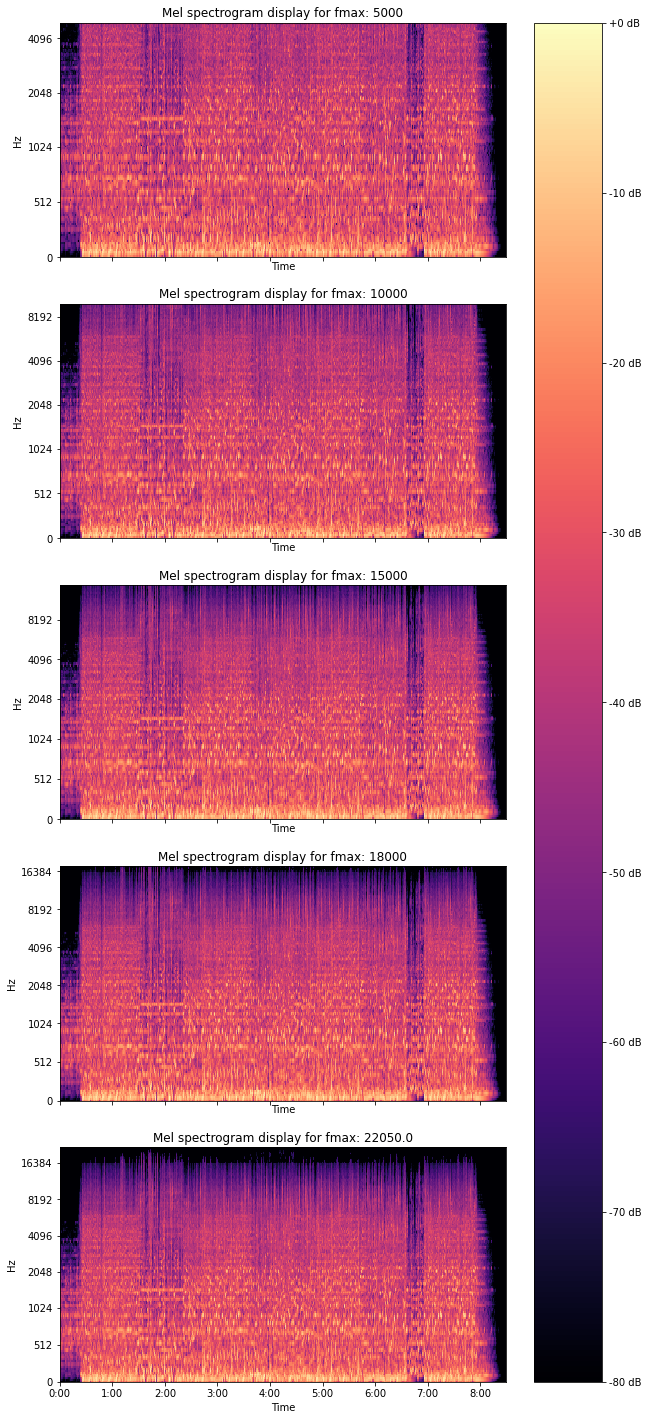

In [38]:
# plotting spectros to ensure the distribution of mel blocks is what I expect

idx = 0
fig, axs = plt.subplots(nrows=len(fmax_range), ncols=1, sharex=True)
fig.set_figheight(25)
fig.set_figwidth(10)
for idx in range(len(fmax_range)):
    img = lbdisplay.specshow(fmax_spectros[idx], y_axis='mel', x_axis='time', ax=axs[idx], fmax=fmax_range[idx])
    axs[idx].set(title=f'Mel spectrogram display for fmax: {fmax_range[idx]}')

fig.colorbar(img, ax=axs, format="%+2.f dB")

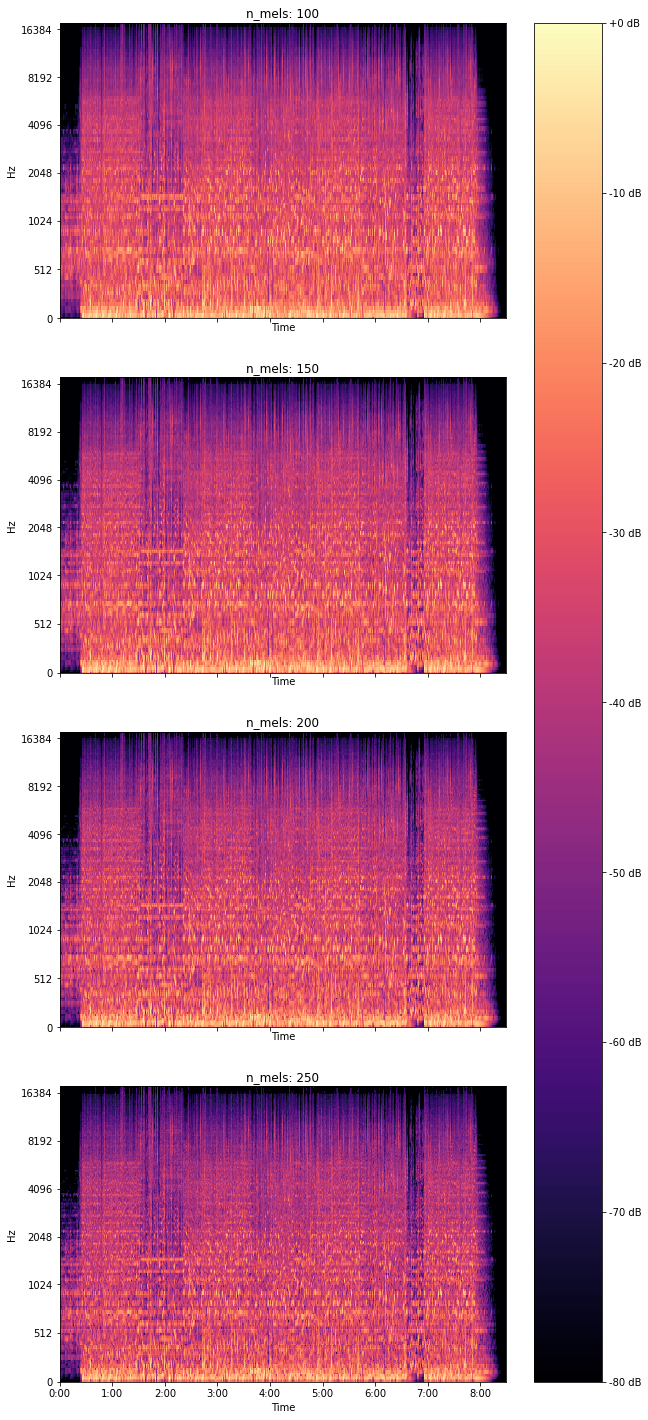

In [43]:
# plotting of different mels
n_mels_list = [100, 150, 200, 250]
fig, axs = plt.subplots(nrows=len(n_mels_list), ncols=1, sharex=True)
fig.set_figheight(25)
fig.set_figwidth(10)
for idx in range(len(n_mels_list)):
    spectro = lb.feature.melspectrogram(lb_song, sr=sr_song, n_fft = window_size, 
                                    hop_length = hop_size,
                                    center = False, n_mels = n_mels_list[idx], fmax=18000)
    spectro_db = lb.power_to_db(spectro, ref = np.max)
    img = lbdisplay.specshow(spectro_db, y_axis='mel', x_axis='time', ax=axs[idx], fmax=18000)
    axs[idx].set(title=f'n_mels: {n_mels_list[idx]}')

fig.colorbar(img, ax=axs, format="%+2.f dB")

In [4]:
# playing back the original song
ipd.display(ipd.Audio(lb_song, rate = sr_song))

Output hidden; open in https://colab.research.google.com to view.

In [18]:
# inverting back to audio signal from mel spectrogram
idx=0
revert_audio = lb.feature.inverse.mel_to_audio(fmax_spectros_pure[idx], sr=sr_song, fmax=fmax_range[idx], n_iter=32,
                                              n_fft=window_size, hop_length=hop_size, center=False)

'''
ABOVE CODE TO INVERT SPECTROGRAM baCK TO AUDIO NEVER FINISHED! It took over 40 minutes and still didn't terminate.

Eventually it terminated, but the revert_audio signal wasn't very loud so I think just based on the 
spectrogram plot above I am going to go with fmax=18000. There's a significant amount of 
'''


"\nABOVE CODE TO INVERT SPECTROGRAM baCK TO AUDIO NEVER FINISHED! It took over 40 minutes and still didn't terminate.\n"

In [35]:
# playing back the changed audio
add_r_a = revert_audio +1
ipd.display(ipd.Audio(revert_audio, rate = sr_song))

Output hidden; open in https://colab.research.google.com to view.

In [34]:
1000*revert_audio.mean()

0.020571598724927753

### Multi-Label KNN Model

I was curious about implementing "simpler" models as a baseline that I could compare other models against, and the "simplest" model that I could think of was KNN. After transforming a song into a spectrogram, we ultimately have a list of n-dimensional vectors that each are assigned a multi-label, multi-class output: KNN can handle this just fine. The main work is getting the data into the correct form for KNN and all into memory, and how to deal with data augmentation as well. KNN  *does not* have an iterative training process, because really there's nothing to "machine learn". KNN has no weights or biases. It's simply placing the points into a high dimensional space and then finding the nearest neighbors and labeling new points based on the k-nearest neighbors in that space. 

### RandomForest Model

### TimeSeriesAI
These subsections deal with exploring TimeSeriesAI python library for usage on the Drum-Tabber project. 

#### ROCKET Model or ROCKET-derived-features powering Other Models